# Neural Contextual Bandits with UCB-based Exploration
Notation:

| Notation                 | Description                                                  |
| :----------------------- | :----------------------------------------------------------- |
| $K$                      | number of arms                                               |
| $T$                      | number of total rounds                                       |
| $t$                      | index of round                                               |
| $x_{t,a}$                | $x_{t,a}\in\mathbb{R}^d$, $a\in [K]$, it is the context, the context consists of $K$ feature vectors $\{x_{t,a}\in\mathbb{R}^d|a\in[K]\}$ |
| $a_t$                    | after observes the context, the agent select an action $a_t$ in round t |
| $r_{t,a_t}$              | the reward after the agent select action $a_t$               |
| $h$                      | we assume that $r_{t,a_t}=h(x_{t,a_t})+\xi_t$, h is an unknown function satisfying $0\le h(x)\le 1$ for any x |
| $\xi_t$                  | $\xi_t$ is v-sub-Gaussian noise conditioned on $x_{1,a_1},\cdots,x_{t-1,a_{t-1}}$, satisfying $\mathbb{E}\xi_t=0$ |
| $L$                      | the depth of neural network                                  |
| $m$                      | number of neural in each layer of network                    |
| $\sigma(x)$              | we define $\sigma(x)=\max\{x,0\}$                            |
| $W_1,\cdots,W_{L-1},W_L$ | the weight in neural network. $W_1\in\mathbb{R}^{m\times d}$, $W_i\in\mathbb{R}^{m\times m}$, $2\le i\le L-1$, $W_L\in\mathbb{R}^{m\times 1}$ |
| $\theta$                 | $\theta=[vec(W_1)^T,\cdots,vec(W_l)^T]\in\mathbb{R}^p$, $p=m+md+m^2(L-1)$ |
| $f(x;\theta)$            | we define $f(x;\theta)=\sqrt{m}W_L\sigma(W_{l-1}\sigma(\cdots\sigma(W_1x)))$ |


<img src="./Figure/NeuralUCB_Initialization.png" style="zoom:80%" />

Initialization of parameters:

<img src="./Figure/NeuralUCB_Initialization.png" style="zoom:80%" />

<img src="./Figure/NeuralUCB_Initialization2.png" style="zoom:80%" />

UCB algorithm:

<img src="./Figure/NeuralUCB_Algorithm1.png" style="zoom:80%" />

<img src="./Figure/NeuralUCB_Algorithm2.png" style="zoom:80%" />

 We assume the reward follows reward = context^T * A^T * A * context + \xi
 
 $\xi$ is a random variable following standard normal distribution N(0, 1)
 
 A is d\*d matrix, randomly generated from N(0, 1)
 
 We assume the context is independent from the action and round index. 
 
 Given action a and round index t, the context is randomly sample from a unit ball in dimension d

In [4]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
type(device)

torch.device

In [1]:
%reset -f
import numpy as np
import random
from copy import deepcopy

from Source.agent import *
from Source.GameSetting import *

In [2]:
# Set the parameter of the game
np.random.seed(12345)
K = 4# Total number of actions, 
T = 10000 # Total number of periods
d = 4 # the dimension of context
A = np.random.normal(loc=0, scale=1, size=(d, d))

In [3]:
# Implement the algorithm
np.random.seed(12345)

# Set the parameter of the network
# the setting is based on the description of section 7.1 of the papaer
L = 2
m = 30 
# we fix gamma in each round, according to the description of section 3.1
gamma_t = 0.01 #{0.01, 0.1, 1, 10}
v = 0.1 #{0.01, 0.1, 1}
lambda_ = 1 #{0.1, 1, 10}
delta = 0.01 #{0.01, 0.1, 1}
S = 0.01 #{0.01, 0.1, 1, 10}
eta = 1e-4 #{0.001, 0.01, 0.1}
frequency = 50
batchsize = 500
verbose = False
# we set J equal to round index t

neuralagent = NeuralAgent(K, T, d, L, m, gamma_t, v, lambda_, delta, S, eta, frequency, batchsize, verbose)
bestagent = BestAgent(K, T, d, A)
uniformagent = UniformAgent(K, T, d)
for tt in range(1, T + 1):
    
    # observe \{x_{t,a}\}_{a=1}^{k=1}
    context_list = SampleContext(d, K)
    realized_reward = GetRealReward(context_list, A)
    
    # neuralagent
    neural_ind = neuralagent.Action(context_list)# make a decision
    neural_reward = realized_reward[neural_ind]# play neural_ind-th arm and observe reward
    neuralagent.Update(neural_reward)
    
    # bestagent
    best_ind = bestagent.Action(context_list)# make a decision
    best_reward = realized_reward[best_ind]# play best_ind-th arm and observe reward
    bestagent.Update(best_reward)
    
    # uniformagent
    uniform_ind = uniformagent.Action(context_list)# make a decision
    uniform_reward = realized_reward[uniform_ind]# play uniform_ind-th arm and observe reward
    uniformagent.Update(uniform_reward)
    
    print("round index {:d}; neural choose {:d}, reward is {:f}; best choose {:d}, reward is {:f}".format(tt,
                                                                                                          neural_ind,
                                                                                                          neural_reward,
                                                                                                          best_ind,
                                                                                                          best_reward,))

Using device cuda:0
round index 1; neural choose 3, reward is 6.666776; best choose 3, reward is 6.666776
round index 2; neural choose 3, reward is 5.186151; best choose 2, reward is 5.908255
round index 3; neural choose 3, reward is 6.140475; best choose 0, reward is 6.648616
round index 4; neural choose 3, reward is 6.597986; best choose 2, reward is 6.691268
round index 5; neural choose 3, reward is 3.298056; best choose 0, reward is 4.934174
round index 6; neural choose 3, reward is 5.176071; best choose 1, reward is 6.128102
round index 7; neural choose 2, reward is 6.796975; best choose 2, reward is 6.796975
round index 8; neural choose 2, reward is 3.449769; best choose 3, reward is 6.706144
round index 9; neural choose 1, reward is 0.587056; best choose 3, reward is 6.086979
round index 10; neural choose 2, reward is 1.360722; best choose 1, reward is 6.629483
round index 11; neural choose 3, reward is 1.822996; best choose 2, reward is 5.535969
round index 12; neural choose 3,

round index 115; neural choose 1, reward is 6.713973; best choose 1, reward is 6.713973
round index 116; neural choose 1, reward is 5.541395; best choose 1, reward is 5.541395
round index 117; neural choose 2, reward is 4.944042; best choose 2, reward is 4.944042
round index 118; neural choose 1, reward is 6.724542; best choose 1, reward is 6.724542
round index 119; neural choose 1, reward is 6.749606; best choose 1, reward is 6.749606
round index 120; neural choose 2, reward is 6.616761; best choose 2, reward is 6.616761
round index 121; neural choose 0, reward is 6.666868; best choose 0, reward is 6.666868
round index 122; neural choose 0, reward is 5.204924; best choose 0, reward is 5.204924
round index 123; neural choose 3, reward is 3.012924; best choose 2, reward is 4.659893
round index 124; neural choose 0, reward is 6.691067; best choose 3, reward is 6.782561
round index 125; neural choose 0, reward is 5.769884; best choose 3, reward is 6.114928
round index 126; neural choose 0

round index 215; neural choose 0, reward is 6.791084; best choose 0, reward is 6.791084
round index 216; neural choose 1, reward is 6.521585; best choose 1, reward is 6.521585
round index 217; neural choose 1, reward is 2.894032; best choose 1, reward is 2.894032
round index 218; neural choose 1, reward is 2.038756; best choose 2, reward is 5.906061
round index 219; neural choose 3, reward is 6.514036; best choose 0, reward is 6.759902
round index 220; neural choose 2, reward is 1.001366; best choose 1, reward is 6.532129
round index 221; neural choose 3, reward is 0.950516; best choose 2, reward is 1.533610
round index 222; neural choose 2, reward is 3.367456; best choose 2, reward is 3.367456
round index 223; neural choose 0, reward is 4.964092; best choose 1, reward is 5.173260
round index 224; neural choose 1, reward is 4.269435; best choose 1, reward is 4.269435
round index 225; neural choose 1, reward is 4.565092; best choose 3, reward is 6.576389
round index 226; neural choose 2

round index 313; neural choose 1, reward is 4.939804; best choose 1, reward is 4.939804
round index 314; neural choose 3, reward is 5.723173; best choose 0, reward is 6.564565
round index 315; neural choose 3, reward is 5.553151; best choose 2, reward is 6.767613
round index 316; neural choose 3, reward is 4.314728; best choose 1, reward is 6.695304
round index 317; neural choose 0, reward is 3.640934; best choose 3, reward is 5.606442
round index 318; neural choose 1, reward is 6.744251; best choose 1, reward is 6.744251
round index 319; neural choose 0, reward is 5.516411; best choose 0, reward is 5.516411
round index 320; neural choose 2, reward is 6.338245; best choose 2, reward is 6.338245
round index 321; neural choose 2, reward is 6.671256; best choose 2, reward is 6.671256
round index 322; neural choose 0, reward is 4.857038; best choose 1, reward is 5.946348
round index 323; neural choose 3, reward is 5.762555; best choose 2, reward is 6.141487
round index 324; neural choose 3

round index 425; neural choose 0, reward is 6.774962; best choose 0, reward is 6.774962
round index 426; neural choose 2, reward is 5.392149; best choose 1, reward is 6.211613
round index 427; neural choose 1, reward is 4.896040; best choose 2, reward is 6.761303
round index 428; neural choose 1, reward is 2.911802; best choose 1, reward is 2.911802
round index 429; neural choose 2, reward is 6.730870; best choose 2, reward is 6.730870
round index 430; neural choose 1, reward is 5.782586; best choose 1, reward is 5.782586
round index 431; neural choose 0, reward is 5.468902; best choose 3, reward is 6.589670
round index 432; neural choose 2, reward is 6.748453; best choose 2, reward is 6.748453
round index 433; neural choose 1, reward is 3.968405; best choose 0, reward is 5.879999
round index 434; neural choose 1, reward is 1.448834; best choose 2, reward is 4.883060
round index 435; neural choose 2, reward is 1.070183; best choose 1, reward is 6.531632
round index 436; neural choose 1

round index 547; neural choose 3, reward is 6.674585; best choose 3, reward is 6.674585
round index 548; neural choose 2, reward is 6.054485; best choose 2, reward is 6.054485
round index 549; neural choose 3, reward is 5.701715; best choose 3, reward is 5.701715
round index 550; neural choose 1, reward is 5.224436; best choose 3, reward is 6.409120
round index 551; neural choose 3, reward is 6.750029; best choose 3, reward is 6.750029
round index 552; neural choose 1, reward is 6.241589; best choose 1, reward is 6.241589
round index 553; neural choose 0, reward is 3.469902; best choose 2, reward is 5.119477
round index 554; neural choose 1, reward is 0.830978; best choose 3, reward is 5.794293
round index 555; neural choose 2, reward is 5.291756; best choose 1, reward is 6.600877
round index 556; neural choose 2, reward is 3.438321; best choose 2, reward is 3.438321
round index 557; neural choose 1, reward is 6.702870; best choose 1, reward is 6.702870
round index 558; neural choose 1

round index 643; neural choose 0, reward is 6.750074; best choose 0, reward is 6.750074
round index 644; neural choose 2, reward is 1.954213; best choose 0, reward is 2.930583
round index 645; neural choose 0, reward is 3.111247; best choose 3, reward is 6.710398
round index 646; neural choose 3, reward is 4.230977; best choose 0, reward is 6.166644
round index 647; neural choose 2, reward is 6.156204; best choose 2, reward is 6.156204
round index 648; neural choose 1, reward is 5.941345; best choose 0, reward is 6.673267
round index 649; neural choose 1, reward is 5.073330; best choose 2, reward is 6.701992
round index 650; neural choose 2, reward is 6.666035; best choose 2, reward is 6.666035
round index 651; neural choose 1, reward is 5.919638; best choose 1, reward is 5.919638
round index 652; neural choose 1, reward is 3.900329; best choose 2, reward is 6.378855
round index 653; neural choose 1, reward is 2.931204; best choose 1, reward is 2.931204
round index 654; neural choose 3

round index 737; neural choose 1, reward is 6.048601; best choose 1, reward is 6.048601
round index 738; neural choose 1, reward is 6.757671; best choose 1, reward is 6.757671
round index 739; neural choose 1, reward is 6.159041; best choose 1, reward is 6.159041
round index 740; neural choose 0, reward is 6.652958; best choose 0, reward is 6.652958
round index 741; neural choose 0, reward is 6.106697; best choose 1, reward is 6.717712
round index 742; neural choose 1, reward is 5.267920; best choose 1, reward is 5.267920
round index 743; neural choose 1, reward is 5.086378; best choose 1, reward is 5.086378
round index 744; neural choose 0, reward is 4.704668; best choose 1, reward is 6.655657
round index 745; neural choose 3, reward is 3.011273; best choose 3, reward is 3.011273
round index 746; neural choose 1, reward is 6.023509; best choose 2, reward is 6.368433
round index 747; neural choose 0, reward is 6.512141; best choose 0, reward is 6.512141
round index 748; neural choose 1

round index 853; neural choose 1, reward is 2.392749; best choose 0, reward is 3.754828
round index 854; neural choose 3, reward is 1.033986; best choose 0, reward is 4.738717
round index 855; neural choose 1, reward is 5.885160; best choose 1, reward is 5.885160
round index 856; neural choose 1, reward is 0.653332; best choose 3, reward is 6.356452
round index 857; neural choose 3, reward is 5.824087; best choose 3, reward is 5.824087
round index 858; neural choose 0, reward is 1.690243; best choose 3, reward is 6.778630
round index 859; neural choose 0, reward is 6.759194; best choose 0, reward is 6.759194
round index 860; neural choose 2, reward is 4.893670; best choose 3, reward is 5.197502
round index 861; neural choose 2, reward is 2.887234; best choose 3, reward is 4.386447
round index 862; neural choose 3, reward is 6.705203; best choose 3, reward is 6.705203
round index 863; neural choose 3, reward is 6.545404; best choose 3, reward is 6.545404
round index 864; neural choose 0

round index 955; neural choose 0, reward is 4.746178; best choose 2, reward is 6.767381
round index 956; neural choose 3, reward is 1.758130; best choose 2, reward is 3.539932
round index 957; neural choose 2, reward is 3.204727; best choose 3, reward is 6.826490
round index 958; neural choose 1, reward is 6.223057; best choose 1, reward is 6.223057
round index 959; neural choose 2, reward is 6.729732; best choose 2, reward is 6.729732
round index 960; neural choose 2, reward is 6.337308; best choose 2, reward is 6.337308
round index 961; neural choose 3, reward is 4.082654; best choose 1, reward is 5.302812
round index 962; neural choose 3, reward is 1.671613; best choose 3, reward is 1.671613
round index 963; neural choose 2, reward is 6.341020; best choose 3, reward is 6.662837
round index 964; neural choose 3, reward is 4.098321; best choose 1, reward is 6.081273
round index 965; neural choose 1, reward is 5.983017; best choose 2, reward is 6.666340
round index 966; neural choose 1

round index 1062; neural choose 3, reward is 4.895254; best choose 0, reward is 5.302899
round index 1063; neural choose 2, reward is 6.160720; best choose 2, reward is 6.160720
round index 1064; neural choose 0, reward is 2.997777; best choose 2, reward is 6.032729
round index 1065; neural choose 1, reward is 4.541859; best choose 1, reward is 4.541859
round index 1066; neural choose 2, reward is 5.760548; best choose 2, reward is 5.760548
round index 1067; neural choose 2, reward is 5.760003; best choose 0, reward is 6.678860
round index 1068; neural choose 2, reward is 3.664026; best choose 3, reward is 4.118963
round index 1069; neural choose 1, reward is 4.925514; best choose 0, reward is 6.636048
round index 1070; neural choose 3, reward is 6.779119; best choose 3, reward is 6.779119
round index 1071; neural choose 2, reward is 5.489441; best choose 3, reward is 6.324972
round index 1072; neural choose 1, reward is 6.291319; best choose 1, reward is 6.291319
round index 1073; neu

round index 1169; neural choose 0, reward is 6.050398; best choose 0, reward is 6.050398
round index 1170; neural choose 1, reward is 6.358857; best choose 1, reward is 6.358857
round index 1171; neural choose 3, reward is 6.619600; best choose 3, reward is 6.619600
round index 1172; neural choose 0, reward is 4.440425; best choose 3, reward is 5.526479
round index 1173; neural choose 0, reward is 6.503521; best choose 0, reward is 6.503521
round index 1174; neural choose 0, reward is 5.226247; best choose 0, reward is 5.226247
round index 1175; neural choose 2, reward is 6.676947; best choose 2, reward is 6.676947
round index 1176; neural choose 0, reward is 1.915388; best choose 1, reward is 6.292124
round index 1177; neural choose 0, reward is 6.010902; best choose 0, reward is 6.010902
round index 1178; neural choose 1, reward is 5.623657; best choose 1, reward is 5.623657
round index 1179; neural choose 2, reward is 6.656832; best choose 0, reward is 6.785730
round index 1180; neu

round index 1265; neural choose 2, reward is 4.094522; best choose 1, reward is 4.334767
round index 1266; neural choose 0, reward is 6.553865; best choose 1, reward is 6.599045
round index 1267; neural choose 1, reward is 4.195603; best choose 1, reward is 4.195603
round index 1268; neural choose 3, reward is 6.598556; best choose 3, reward is 6.598556
round index 1269; neural choose 0, reward is 6.143001; best choose 0, reward is 6.143001
round index 1270; neural choose 3, reward is 3.577279; best choose 1, reward is 6.358771
round index 1271; neural choose 2, reward is 6.615784; best choose 2, reward is 6.615784
round index 1272; neural choose 3, reward is 6.601857; best choose 3, reward is 6.601857
round index 1273; neural choose 1, reward is 6.674046; best choose 1, reward is 6.674046
round index 1274; neural choose 0, reward is 1.909593; best choose 1, reward is 5.306170
round index 1275; neural choose 3, reward is 6.616462; best choose 3, reward is 6.616462
round index 1276; neu

round index 1361; neural choose 1, reward is 6.618877; best choose 1, reward is 6.618877
round index 1362; neural choose 3, reward is 3.955529; best choose 3, reward is 3.955529
round index 1363; neural choose 0, reward is 6.084848; best choose 0, reward is 6.084848
round index 1364; neural choose 1, reward is 5.686288; best choose 1, reward is 5.686288
round index 1365; neural choose 0, reward is 0.602637; best choose 1, reward is 2.791667
round index 1366; neural choose 3, reward is 4.070150; best choose 0, reward is 5.112175
round index 1367; neural choose 2, reward is 6.327056; best choose 2, reward is 6.327056
round index 1368; neural choose 2, reward is 6.653673; best choose 2, reward is 6.653673
round index 1369; neural choose 2, reward is 6.768582; best choose 2, reward is 6.768582
round index 1370; neural choose 2, reward is 5.763151; best choose 0, reward is 6.641236
round index 1371; neural choose 3, reward is 6.587624; best choose 3, reward is 6.587624
round index 1372; neu

round index 1464; neural choose 3, reward is 6.648346; best choose 3, reward is 6.648346
round index 1465; neural choose 0, reward is 6.350725; best choose 0, reward is 6.350725
round index 1466; neural choose 1, reward is 5.284153; best choose 1, reward is 5.284153
round index 1467; neural choose 1, reward is 6.669773; best choose 1, reward is 6.669773
round index 1468; neural choose 1, reward is 6.656539; best choose 1, reward is 6.656539
round index 1469; neural choose 2, reward is 6.298459; best choose 1, reward is 6.440423
round index 1470; neural choose 2, reward is 6.752463; best choose 2, reward is 6.752463
round index 1471; neural choose 3, reward is 4.482555; best choose 1, reward is 6.681783
round index 1472; neural choose 2, reward is 5.637307; best choose 2, reward is 5.637307
round index 1473; neural choose 2, reward is 6.702758; best choose 2, reward is 6.702758
round index 1474; neural choose 0, reward is 6.294507; best choose 0, reward is 6.294507
round index 1475; neu

round index 1570; neural choose 0, reward is 4.120218; best choose 0, reward is 4.120218
round index 1571; neural choose 1, reward is 6.032651; best choose 1, reward is 6.032651
round index 1572; neural choose 0, reward is 6.748831; best choose 0, reward is 6.748831
round index 1573; neural choose 3, reward is 6.598522; best choose 3, reward is 6.598522
round index 1574; neural choose 1, reward is 5.822893; best choose 0, reward is 6.296060
round index 1575; neural choose 3, reward is 5.054885; best choose 3, reward is 5.054885
round index 1576; neural choose 3, reward is 6.681996; best choose 2, reward is 6.687597
round index 1577; neural choose 3, reward is 5.318748; best choose 3, reward is 5.318748
round index 1578; neural choose 1, reward is 5.645222; best choose 1, reward is 5.645222
round index 1579; neural choose 1, reward is 6.617008; best choose 1, reward is 6.617008
round index 1580; neural choose 2, reward is 6.788917; best choose 2, reward is 6.788917
round index 1581; neu

round index 1674; neural choose 3, reward is 5.414956; best choose 3, reward is 5.414956
round index 1675; neural choose 2, reward is 6.343712; best choose 2, reward is 6.343712
round index 1676; neural choose 2, reward is 6.293405; best choose 1, reward is 6.346679
round index 1677; neural choose 3, reward is 6.711037; best choose 3, reward is 6.711037
round index 1678; neural choose 0, reward is 5.436491; best choose 0, reward is 5.436491
round index 1679; neural choose 3, reward is 6.630891; best choose 3, reward is 6.630891
round index 1680; neural choose 1, reward is 5.839712; best choose 1, reward is 5.839712
round index 1681; neural choose 3, reward is 6.770743; best choose 3, reward is 6.770743
round index 1682; neural choose 0, reward is 3.976416; best choose 0, reward is 3.976416
round index 1683; neural choose 3, reward is 5.171724; best choose 3, reward is 5.171724
round index 1684; neural choose 3, reward is 6.438616; best choose 3, reward is 6.438616
round index 1685; neu

round index 1785; neural choose 2, reward is 6.453719; best choose 1, reward is 6.810225
round index 1786; neural choose 3, reward is 6.110967; best choose 3, reward is 6.110967
round index 1787; neural choose 0, reward is 5.130133; best choose 0, reward is 5.130133
round index 1788; neural choose 0, reward is 5.503558; best choose 0, reward is 5.503558
round index 1789; neural choose 2, reward is 6.550967; best choose 2, reward is 6.550967
round index 1790; neural choose 1, reward is 3.064763; best choose 1, reward is 3.064763
round index 1791; neural choose 1, reward is 4.629031; best choose 1, reward is 4.629031
round index 1792; neural choose 0, reward is 5.650579; best choose 0, reward is 5.650579
round index 1793; neural choose 1, reward is 6.474102; best choose 1, reward is 6.474102
round index 1794; neural choose 1, reward is 3.749882; best choose 1, reward is 3.749882
round index 1795; neural choose 3, reward is 3.541589; best choose 3, reward is 3.541589
round index 1796; neu

round index 1885; neural choose 2, reward is 5.046016; best choose 2, reward is 5.046016
round index 1886; neural choose 1, reward is 6.662965; best choose 1, reward is 6.662965
round index 1887; neural choose 3, reward is 5.688205; best choose 3, reward is 5.688205
round index 1888; neural choose 1, reward is 5.694830; best choose 0, reward is 5.724577
round index 1889; neural choose 1, reward is 6.715263; best choose 1, reward is 6.715263
round index 1890; neural choose 0, reward is 6.715357; best choose 0, reward is 6.715357
round index 1891; neural choose 2, reward is 4.492492; best choose 2, reward is 4.492492
round index 1892; neural choose 2, reward is 6.554168; best choose 3, reward is 6.720064
round index 1893; neural choose 3, reward is 5.248780; best choose 3, reward is 5.248780
round index 1894; neural choose 2, reward is 6.684073; best choose 2, reward is 6.684073
round index 1895; neural choose 1, reward is 6.680506; best choose 1, reward is 6.680506
round index 1896; neu

round index 1987; neural choose 0, reward is 6.619497; best choose 0, reward is 6.619497
round index 1988; neural choose 2, reward is 6.639627; best choose 2, reward is 6.639627
round index 1989; neural choose 2, reward is 5.531324; best choose 2, reward is 5.531324
round index 1990; neural choose 3, reward is 4.734529; best choose 3, reward is 4.734529
round index 1991; neural choose 2, reward is 6.763822; best choose 2, reward is 6.763822
round index 1992; neural choose 0, reward is 5.890040; best choose 0, reward is 5.890040
round index 1993; neural choose 3, reward is 3.705424; best choose 3, reward is 3.705424
round index 1994; neural choose 2, reward is 6.219777; best choose 2, reward is 6.219777
round index 1995; neural choose 0, reward is 6.474707; best choose 0, reward is 6.474707
round index 1996; neural choose 2, reward is 6.726844; best choose 2, reward is 6.726844
round index 1997; neural choose 1, reward is 6.731707; best choose 1, reward is 6.731707
round index 1998; neu

round index 2080; neural choose 2, reward is 6.289011; best choose 2, reward is 6.289011
round index 2081; neural choose 2, reward is 5.119127; best choose 2, reward is 5.119127
round index 2082; neural choose 0, reward is 6.461621; best choose 0, reward is 6.461621
round index 2083; neural choose 3, reward is 6.321324; best choose 3, reward is 6.321324
round index 2084; neural choose 1, reward is 6.620286; best choose 1, reward is 6.620286
round index 2085; neural choose 3, reward is 6.676279; best choose 3, reward is 6.676279
round index 2086; neural choose 3, reward is 6.762271; best choose 3, reward is 6.762271
round index 2087; neural choose 1, reward is 3.750125; best choose 1, reward is 3.750125
round index 2088; neural choose 2, reward is 6.511084; best choose 2, reward is 6.511084
round index 2089; neural choose 3, reward is 6.607587; best choose 3, reward is 6.607587
round index 2090; neural choose 0, reward is 3.080151; best choose 0, reward is 3.080151
round index 2091; neu

round index 2188; neural choose 1, reward is 6.721484; best choose 1, reward is 6.721484
round index 2189; neural choose 1, reward is 6.766098; best choose 1, reward is 6.766098
round index 2190; neural choose 3, reward is 4.657547; best choose 3, reward is 4.657547
round index 2191; neural choose 0, reward is 6.466653; best choose 0, reward is 6.466653
round index 2192; neural choose 2, reward is 6.726921; best choose 2, reward is 6.726921
round index 2193; neural choose 3, reward is 5.856564; best choose 3, reward is 5.856564
round index 2194; neural choose 0, reward is 6.646244; best choose 0, reward is 6.646244
round index 2195; neural choose 0, reward is 5.761736; best choose 0, reward is 5.761736
round index 2196; neural choose 0, reward is 5.896712; best choose 0, reward is 5.896712
round index 2197; neural choose 1, reward is 6.528913; best choose 1, reward is 6.528913
round index 2198; neural choose 3, reward is 4.467872; best choose 0, reward is 4.531375
round index 2199; neu

round index 2284; neural choose 1, reward is 6.613986; best choose 1, reward is 6.613986
round index 2285; neural choose 3, reward is 6.671423; best choose 3, reward is 6.671423
round index 2286; neural choose 3, reward is 6.711193; best choose 3, reward is 6.711193
round index 2287; neural choose 0, reward is 6.090422; best choose 0, reward is 6.090422
round index 2288; neural choose 3, reward is 6.710253; best choose 3, reward is 6.710253
round index 2289; neural choose 2, reward is 6.530377; best choose 2, reward is 6.530377
round index 2290; neural choose 2, reward is 5.976825; best choose 2, reward is 5.976825
round index 2291; neural choose 2, reward is 6.629740; best choose 2, reward is 6.629740
round index 2292; neural choose 1, reward is 5.601925; best choose 1, reward is 5.601925
round index 2293; neural choose 1, reward is 5.631049; best choose 1, reward is 5.631049
round index 2294; neural choose 1, reward is 6.445708; best choose 1, reward is 6.445708
round index 2295; neu

round index 2377; neural choose 2, reward is 6.246251; best choose 2, reward is 6.246251
round index 2378; neural choose 1, reward is 6.658711; best choose 1, reward is 6.658711
round index 2379; neural choose 3, reward is 4.258012; best choose 3, reward is 4.258012
round index 2380; neural choose 3, reward is 4.305648; best choose 3, reward is 4.305648
round index 2381; neural choose 3, reward is 6.110332; best choose 3, reward is 6.110332
round index 2382; neural choose 2, reward is 6.689616; best choose 2, reward is 6.689616
round index 2383; neural choose 2, reward is 3.916866; best choose 2, reward is 3.916866
round index 2384; neural choose 2, reward is 6.589313; best choose 2, reward is 6.589313
round index 2385; neural choose 0, reward is 6.452485; best choose 0, reward is 6.452485
round index 2386; neural choose 1, reward is 5.362429; best choose 1, reward is 5.362429
round index 2387; neural choose 2, reward is 4.268623; best choose 2, reward is 4.268623
round index 2388; neu

round index 2480; neural choose 1, reward is 6.684292; best choose 1, reward is 6.684292
round index 2481; neural choose 2, reward is 6.735491; best choose 2, reward is 6.735491
round index 2482; neural choose 2, reward is 6.458462; best choose 2, reward is 6.458462
round index 2483; neural choose 2, reward is 5.411895; best choose 2, reward is 5.411895
round index 2484; neural choose 0, reward is 6.603504; best choose 1, reward is 6.564759
round index 2485; neural choose 1, reward is 6.287398; best choose 1, reward is 6.287398
round index 2486; neural choose 1, reward is 6.678365; best choose 1, reward is 6.678365
round index 2487; neural choose 3, reward is 2.975782; best choose 3, reward is 2.975782
round index 2488; neural choose 1, reward is 5.633799; best choose 1, reward is 5.633799
round index 2489; neural choose 3, reward is 6.689848; best choose 3, reward is 6.689848
round index 2490; neural choose 2, reward is 6.490251; best choose 2, reward is 6.490251
round index 2491; neu

round index 2587; neural choose 3, reward is 6.322328; best choose 3, reward is 6.322328
round index 2588; neural choose 2, reward is 3.251525; best choose 2, reward is 3.251525
round index 2589; neural choose 0, reward is 6.161453; best choose 0, reward is 6.161453
round index 2590; neural choose 3, reward is 2.273495; best choose 3, reward is 2.273495
round index 2591; neural choose 2, reward is 6.187644; best choose 2, reward is 6.187644
round index 2592; neural choose 2, reward is 6.686106; best choose 2, reward is 6.686106
round index 2593; neural choose 0, reward is 4.520299; best choose 0, reward is 4.520299
round index 2594; neural choose 0, reward is 5.569655; best choose 0, reward is 5.569655
round index 2595; neural choose 2, reward is 5.832969; best choose 2, reward is 5.832969
round index 2596; neural choose 2, reward is 6.625325; best choose 2, reward is 6.625325
round index 2597; neural choose 2, reward is 6.554785; best choose 2, reward is 6.554785
round index 2598; neu

round index 2683; neural choose 2, reward is 6.575618; best choose 2, reward is 6.575618
round index 2684; neural choose 1, reward is 6.682314; best choose 1, reward is 6.682314
round index 2685; neural choose 2, reward is 2.497708; best choose 2, reward is 2.497708
round index 2686; neural choose 0, reward is 4.858667; best choose 0, reward is 4.858667
round index 2687; neural choose 1, reward is 6.788629; best choose 1, reward is 6.788629
round index 2688; neural choose 2, reward is 6.073597; best choose 2, reward is 6.073597
round index 2689; neural choose 0, reward is 1.805975; best choose 0, reward is 1.805975
round index 2690; neural choose 0, reward is 6.702169; best choose 0, reward is 6.702169
round index 2691; neural choose 3, reward is 6.677118; best choose 3, reward is 6.677118
round index 2692; neural choose 1, reward is 5.928104; best choose 1, reward is 5.928104
round index 2693; neural choose 3, reward is 5.845074; best choose 3, reward is 5.845074
round index 2694; neu

round index 2778; neural choose 2, reward is 5.731393; best choose 2, reward is 5.731393
round index 2779; neural choose 1, reward is 6.685766; best choose 1, reward is 6.685766
round index 2780; neural choose 0, reward is 6.546310; best choose 0, reward is 6.546310
round index 2781; neural choose 1, reward is 6.732067; best choose 1, reward is 6.732067
round index 2782; neural choose 2, reward is 5.876240; best choose 2, reward is 5.876240
round index 2783; neural choose 0, reward is 4.604209; best choose 0, reward is 4.604209
round index 2784; neural choose 1, reward is 6.306097; best choose 1, reward is 6.306097
round index 2785; neural choose 3, reward is 6.769764; best choose 3, reward is 6.769764
round index 2786; neural choose 2, reward is 6.683021; best choose 2, reward is 6.683021
round index 2787; neural choose 3, reward is 6.578447; best choose 3, reward is 6.578447
round index 2788; neural choose 1, reward is 6.692864; best choose 1, reward is 6.692864
round index 2789; neu

round index 2872; neural choose 3, reward is 4.783531; best choose 3, reward is 4.783531
round index 2873; neural choose 0, reward is 4.013496; best choose 0, reward is 4.013496
round index 2874; neural choose 0, reward is 6.781199; best choose 0, reward is 6.781199
round index 2875; neural choose 0, reward is 5.981808; best choose 0, reward is 5.981808
round index 2876; neural choose 1, reward is 6.727771; best choose 1, reward is 6.727771
round index 2877; neural choose 0, reward is 6.365561; best choose 0, reward is 6.365561
round index 2878; neural choose 2, reward is 6.671855; best choose 2, reward is 6.671855
round index 2879; neural choose 2, reward is 6.581502; best choose 2, reward is 6.581502
round index 2880; neural choose 2, reward is 5.642313; best choose 2, reward is 5.642313
round index 2881; neural choose 3, reward is 6.443113; best choose 3, reward is 6.443113
round index 2882; neural choose 1, reward is 6.584548; best choose 1, reward is 6.584548
round index 2883; neu

round index 2966; neural choose 1, reward is 5.943200; best choose 1, reward is 5.943200
round index 2967; neural choose 2, reward is 5.835295; best choose 2, reward is 5.835295
round index 2968; neural choose 0, reward is 1.394970; best choose 0, reward is 1.394970
round index 2969; neural choose 2, reward is 5.057720; best choose 2, reward is 5.057720
round index 2970; neural choose 2, reward is 6.116075; best choose 2, reward is 6.116075
round index 2971; neural choose 2, reward is 6.506453; best choose 2, reward is 6.506453
round index 2972; neural choose 1, reward is 6.722578; best choose 1, reward is 6.722578
round index 2973; neural choose 2, reward is 6.668510; best choose 2, reward is 6.668510
round index 2974; neural choose 3, reward is 6.624279; best choose 1, reward is 6.603644
round index 2975; neural choose 0, reward is 6.090374; best choose 0, reward is 6.090374
round index 2976; neural choose 2, reward is 5.783795; best choose 2, reward is 5.783795
round index 2977; neu

round index 3074; neural choose 2, reward is 6.728443; best choose 2, reward is 6.728443
round index 3075; neural choose 2, reward is 5.066912; best choose 2, reward is 5.066912
round index 3076; neural choose 2, reward is 6.746320; best choose 2, reward is 6.746320
round index 3077; neural choose 2, reward is 6.642997; best choose 2, reward is 6.642997
round index 3078; neural choose 2, reward is 5.246647; best choose 2, reward is 5.246647
round index 3079; neural choose 2, reward is 6.753385; best choose 2, reward is 6.753385
round index 3080; neural choose 0, reward is 6.660556; best choose 0, reward is 6.660556
round index 3081; neural choose 0, reward is 5.223835; best choose 0, reward is 5.223835
round index 3082; neural choose 2, reward is 6.532960; best choose 2, reward is 6.532960
round index 3083; neural choose 3, reward is 6.005305; best choose 3, reward is 6.005305
round index 3084; neural choose 3, reward is 6.735653; best choose 3, reward is 6.735653
round index 3085; neu

round index 3184; neural choose 3, reward is 5.832699; best choose 3, reward is 5.832699
round index 3185; neural choose 1, reward is 5.865360; best choose 1, reward is 5.865360
round index 3186; neural choose 0, reward is 6.417105; best choose 0, reward is 6.417105
round index 3187; neural choose 1, reward is 6.026125; best choose 1, reward is 6.026125
round index 3188; neural choose 1, reward is 6.744785; best choose 1, reward is 6.744785
round index 3189; neural choose 3, reward is 6.440513; best choose 3, reward is 6.440513
round index 3190; neural choose 1, reward is 6.450400; best choose 1, reward is 6.450400
round index 3191; neural choose 2, reward is 6.587973; best choose 2, reward is 6.587973
round index 3192; neural choose 0, reward is 4.984524; best choose 0, reward is 4.984524
round index 3193; neural choose 3, reward is 3.458168; best choose 3, reward is 3.458168
round index 3194; neural choose 0, reward is 1.957970; best choose 0, reward is 1.957970
round index 3195; neu

round index 3295; neural choose 3, reward is 6.608438; best choose 3, reward is 6.608438
round index 3296; neural choose 3, reward is 4.608547; best choose 3, reward is 4.608547
round index 3297; neural choose 2, reward is 5.141268; best choose 2, reward is 5.141268
round index 3298; neural choose 3, reward is 6.596321; best choose 3, reward is 6.596321
round index 3299; neural choose 2, reward is 5.914973; best choose 2, reward is 5.914973
round index 3300; neural choose 3, reward is 5.389167; best choose 3, reward is 5.389167
round index 3301; neural choose 3, reward is 6.653913; best choose 3, reward is 6.653913
round index 3302; neural choose 1, reward is 6.519418; best choose 1, reward is 6.519418
round index 3303; neural choose 2, reward is 6.673325; best choose 2, reward is 6.673325
round index 3304; neural choose 0, reward is 6.762054; best choose 0, reward is 6.762054
round index 3305; neural choose 3, reward is 5.797688; best choose 3, reward is 5.797688
round index 3306; neu

round index 3389; neural choose 2, reward is 6.180877; best choose 2, reward is 6.180877
round index 3390; neural choose 0, reward is 5.379732; best choose 0, reward is 5.379732
round index 3391; neural choose 3, reward is 6.681559; best choose 3, reward is 6.681559
round index 3392; neural choose 3, reward is 6.601706; best choose 3, reward is 6.601706
round index 3393; neural choose 0, reward is 6.247135; best choose 0, reward is 6.247135
round index 3394; neural choose 0, reward is 5.985655; best choose 0, reward is 5.985655
round index 3395; neural choose 3, reward is 6.493465; best choose 3, reward is 6.493465
round index 3396; neural choose 1, reward is 6.086392; best choose 1, reward is 6.086392
round index 3397; neural choose 1, reward is 5.113007; best choose 1, reward is 5.113007
round index 3398; neural choose 1, reward is 3.243706; best choose 1, reward is 3.243706
round index 3399; neural choose 3, reward is 5.829510; best choose 3, reward is 5.829510
round index 3400; neu

round index 3499; neural choose 3, reward is 4.239104; best choose 3, reward is 4.239104
round index 3500; neural choose 0, reward is 6.069487; best choose 0, reward is 6.069487
round index 3501; neural choose 0, reward is 6.288779; best choose 0, reward is 6.288779
round index 3502; neural choose 3, reward is 6.747675; best choose 3, reward is 6.747675
round index 3503; neural choose 1, reward is 6.629950; best choose 1, reward is 6.629950
round index 3504; neural choose 0, reward is 6.650250; best choose 1, reward is 6.724873
round index 3505; neural choose 0, reward is 5.576291; best choose 0, reward is 5.576291
round index 3506; neural choose 3, reward is 6.403442; best choose 3, reward is 6.403442
round index 3507; neural choose 1, reward is 5.244556; best choose 1, reward is 5.244556
round index 3508; neural choose 2, reward is 6.022011; best choose 2, reward is 6.022011
round index 3509; neural choose 1, reward is 6.190774; best choose 1, reward is 6.190774
round index 3510; neu

round index 3592; neural choose 2, reward is 6.658205; best choose 2, reward is 6.658205
round index 3593; neural choose 2, reward is 6.701423; best choose 2, reward is 6.701423
round index 3594; neural choose 0, reward is 4.702641; best choose 0, reward is 4.702641
round index 3595; neural choose 2, reward is 6.696772; best choose 2, reward is 6.696772
round index 3596; neural choose 3, reward is 6.405475; best choose 3, reward is 6.405475
round index 3597; neural choose 0, reward is 6.204666; best choose 0, reward is 6.204666
round index 3598; neural choose 3, reward is 3.633936; best choose 3, reward is 3.633936
round index 3599; neural choose 0, reward is 6.273723; best choose 0, reward is 6.273723
round index 3600; neural choose 3, reward is 6.164425; best choose 3, reward is 6.164425
round index 3601; neural choose 2, reward is 6.051376; best choose 2, reward is 6.051376
round index 3602; neural choose 2, reward is 6.779480; best choose 2, reward is 6.779480
round index 3603; neu

round index 3687; neural choose 2, reward is 6.577430; best choose 2, reward is 6.577430
round index 3688; neural choose 0, reward is 6.227170; best choose 0, reward is 6.227170
round index 3689; neural choose 0, reward is 5.822992; best choose 0, reward is 5.822992
round index 3690; neural choose 3, reward is 6.693893; best choose 3, reward is 6.693893
round index 3691; neural choose 3, reward is 5.329282; best choose 3, reward is 5.329282
round index 3692; neural choose 3, reward is 6.021592; best choose 3, reward is 6.021592
round index 3693; neural choose 1, reward is 6.656018; best choose 1, reward is 6.656018
round index 3694; neural choose 3, reward is 6.709724; best choose 3, reward is 6.709724
round index 3695; neural choose 3, reward is 2.490648; best choose 3, reward is 2.490648
round index 3696; neural choose 2, reward is 4.086165; best choose 2, reward is 4.086165
round index 3697; neural choose 1, reward is 5.615020; best choose 1, reward is 5.615020
round index 3698; neu

round index 3791; neural choose 3, reward is 5.706605; best choose 3, reward is 5.706605
round index 3792; neural choose 2, reward is 6.499510; best choose 2, reward is 6.499510
round index 3793; neural choose 2, reward is 6.684654; best choose 2, reward is 6.684654
round index 3794; neural choose 3, reward is 6.314482; best choose 3, reward is 6.314482
round index 3795; neural choose 0, reward is 4.817816; best choose 0, reward is 4.817816
round index 3796; neural choose 2, reward is 6.615122; best choose 2, reward is 6.615122
round index 3797; neural choose 0, reward is 6.440903; best choose 0, reward is 6.440903
round index 3798; neural choose 0, reward is 6.553813; best choose 0, reward is 6.553813
round index 3799; neural choose 2, reward is 6.819293; best choose 2, reward is 6.819293
round index 3800; neural choose 1, reward is 6.171576; best choose 1, reward is 6.171576
round index 3801; neural choose 3, reward is 6.485820; best choose 3, reward is 6.485820
round index 3802; neu

round index 3900; neural choose 0, reward is 6.779578; best choose 0, reward is 6.779578
round index 3901; neural choose 0, reward is 6.576198; best choose 0, reward is 6.576198
round index 3902; neural choose 2, reward is 2.627210; best choose 2, reward is 2.627210
round index 3903; neural choose 3, reward is 6.747852; best choose 3, reward is 6.747852
round index 3904; neural choose 3, reward is 1.446136; best choose 3, reward is 1.446136
round index 3905; neural choose 2, reward is 6.120363; best choose 2, reward is 6.120363
round index 3906; neural choose 2, reward is 5.950227; best choose 2, reward is 5.950227
round index 3907; neural choose 1, reward is 5.769665; best choose 1, reward is 5.769665
round index 3908; neural choose 0, reward is 4.855101; best choose 0, reward is 4.855101
round index 3909; neural choose 1, reward is 5.199240; best choose 1, reward is 5.199240
round index 3910; neural choose 2, reward is 6.654493; best choose 2, reward is 6.654493
round index 3911; neu

round index 4008; neural choose 3, reward is 6.590196; best choose 3, reward is 6.590196
round index 4009; neural choose 3, reward is 6.449647; best choose 3, reward is 6.449647
round index 4010; neural choose 0, reward is 5.968280; best choose 0, reward is 5.968280
round index 4011; neural choose 0, reward is 6.476868; best choose 0, reward is 6.476868
round index 4012; neural choose 2, reward is 6.519799; best choose 2, reward is 6.519799
round index 4013; neural choose 2, reward is 6.665306; best choose 2, reward is 6.665306
round index 4014; neural choose 0, reward is 6.157510; best choose 0, reward is 6.157510
round index 4015; neural choose 2, reward is 6.420807; best choose 2, reward is 6.420807
round index 4016; neural choose 3, reward is 6.223169; best choose 3, reward is 6.223169
round index 4017; neural choose 2, reward is 3.577793; best choose 2, reward is 3.577793
round index 4018; neural choose 2, reward is 5.722359; best choose 2, reward is 5.722359
round index 4019; neu

round index 4108; neural choose 0, reward is 6.639188; best choose 0, reward is 6.639188
round index 4109; neural choose 2, reward is 6.646460; best choose 2, reward is 6.646460
round index 4110; neural choose 0, reward is 5.571593; best choose 0, reward is 5.571593
round index 4111; neural choose 1, reward is 6.710259; best choose 1, reward is 6.710259
round index 4112; neural choose 0, reward is 5.885224; best choose 0, reward is 5.885224
round index 4113; neural choose 0, reward is 3.872724; best choose 0, reward is 3.872724
round index 4114; neural choose 1, reward is 6.219948; best choose 1, reward is 6.219948
round index 4115; neural choose 3, reward is 4.756838; best choose 3, reward is 4.756838
round index 4116; neural choose 2, reward is 6.305860; best choose 2, reward is 6.305860
round index 4117; neural choose 3, reward is 6.750669; best choose 3, reward is 6.750669
round index 4118; neural choose 0, reward is 6.019987; best choose 0, reward is 6.019987
round index 4119; neu

round index 4205; neural choose 1, reward is 5.913489; best choose 1, reward is 5.913489
round index 4206; neural choose 2, reward is 6.629329; best choose 2, reward is 6.629329
round index 4207; neural choose 0, reward is 6.731148; best choose 0, reward is 6.731148
round index 4208; neural choose 3, reward is 6.700664; best choose 3, reward is 6.700664
round index 4209; neural choose 0, reward is 6.434442; best choose 0, reward is 6.434442
round index 4210; neural choose 3, reward is 5.730103; best choose 3, reward is 5.730103
round index 4211; neural choose 3, reward is 6.606778; best choose 3, reward is 6.606778
round index 4212; neural choose 3, reward is 3.203993; best choose 3, reward is 3.203993
round index 4213; neural choose 1, reward is 6.531031; best choose 1, reward is 6.531031
round index 4214; neural choose 0, reward is 6.672496; best choose 0, reward is 6.672496
round index 4215; neural choose 0, reward is 6.498057; best choose 0, reward is 6.498057
round index 4216; neu

round index 4303; neural choose 1, reward is 6.059167; best choose 1, reward is 6.059167
round index 4304; neural choose 2, reward is 6.692942; best choose 2, reward is 6.692942
round index 4305; neural choose 3, reward is 6.222907; best choose 3, reward is 6.222907
round index 4306; neural choose 0, reward is 6.616070; best choose 0, reward is 6.616070
round index 4307; neural choose 3, reward is 1.897061; best choose 3, reward is 1.897061
round index 4308; neural choose 0, reward is 6.627154; best choose 0, reward is 6.627154
round index 4309; neural choose 1, reward is 5.754647; best choose 1, reward is 5.754647
round index 4310; neural choose 2, reward is 6.093603; best choose 2, reward is 6.093603
round index 4311; neural choose 0, reward is 5.836282; best choose 0, reward is 5.836282
round index 4312; neural choose 0, reward is 5.209815; best choose 0, reward is 5.209815
round index 4313; neural choose 1, reward is 5.724967; best choose 1, reward is 5.724967
round index 4314; neu

round index 4405; neural choose 2, reward is 4.612027; best choose 2, reward is 4.612027
round index 4406; neural choose 0, reward is 6.689026; best choose 0, reward is 6.689026
round index 4407; neural choose 1, reward is 4.836820; best choose 1, reward is 4.836820
round index 4408; neural choose 3, reward is 6.595537; best choose 3, reward is 6.595537
round index 4409; neural choose 0, reward is 6.790231; best choose 0, reward is 6.790231
round index 4410; neural choose 1, reward is 6.731091; best choose 1, reward is 6.731091
round index 4411; neural choose 3, reward is 5.391776; best choose 3, reward is 5.391776
round index 4412; neural choose 3, reward is 5.678524; best choose 3, reward is 5.678524
round index 4413; neural choose 1, reward is 6.632971; best choose 1, reward is 6.632971
round index 4414; neural choose 1, reward is 5.035049; best choose 1, reward is 5.035049
round index 4415; neural choose 0, reward is 6.489246; best choose 0, reward is 6.489246
round index 4416; neu

round index 4508; neural choose 2, reward is 6.181061; best choose 2, reward is 6.181061
round index 4509; neural choose 0, reward is 6.818903; best choose 0, reward is 6.818903
round index 4510; neural choose 1, reward is 6.653437; best choose 1, reward is 6.653437
round index 4511; neural choose 3, reward is 6.733034; best choose 3, reward is 6.733034
round index 4512; neural choose 2, reward is 6.712108; best choose 2, reward is 6.712108
round index 4513; neural choose 3, reward is 5.346080; best choose 3, reward is 5.346080
round index 4514; neural choose 0, reward is 6.608529; best choose 0, reward is 6.608529
round index 4515; neural choose 3, reward is 5.438269; best choose 3, reward is 5.438269
round index 4516; neural choose 0, reward is 6.557975; best choose 0, reward is 6.557975
round index 4517; neural choose 0, reward is 6.380031; best choose 0, reward is 6.380031
round index 4518; neural choose 1, reward is 6.574898; best choose 1, reward is 6.574898
round index 4519; neu

round index 4602; neural choose 0, reward is 6.526197; best choose 0, reward is 6.526197
round index 4603; neural choose 1, reward is 6.739196; best choose 1, reward is 6.739196
round index 4604; neural choose 0, reward is 6.295878; best choose 0, reward is 6.295878
round index 4605; neural choose 1, reward is 6.644428; best choose 1, reward is 6.644428
round index 4606; neural choose 2, reward is 6.796299; best choose 2, reward is 6.796299
round index 4607; neural choose 0, reward is 5.870239; best choose 0, reward is 5.870239
round index 4608; neural choose 2, reward is 5.769310; best choose 2, reward is 5.769310
round index 4609; neural choose 0, reward is 6.094002; best choose 0, reward is 6.094002
round index 4610; neural choose 2, reward is 6.405344; best choose 2, reward is 6.405344
round index 4611; neural choose 0, reward is 6.378650; best choose 0, reward is 6.378650
round index 4612; neural choose 0, reward is 6.418255; best choose 0, reward is 6.418255
round index 4613; neu

round index 4700; neural choose 2, reward is 3.571091; best choose 2, reward is 3.571091
round index 4701; neural choose 3, reward is 6.271229; best choose 3, reward is 6.271229
round index 4702; neural choose 0, reward is 6.704115; best choose 0, reward is 6.704115
round index 4703; neural choose 2, reward is 6.177941; best choose 2, reward is 6.177941
round index 4704; neural choose 3, reward is 6.702316; best choose 3, reward is 6.702316
round index 4705; neural choose 0, reward is 6.660385; best choose 0, reward is 6.660385
round index 4706; neural choose 3, reward is 6.696822; best choose 3, reward is 6.696822
round index 4707; neural choose 1, reward is 4.214794; best choose 1, reward is 4.214794
round index 4708; neural choose 1, reward is 4.785978; best choose 1, reward is 4.785978
round index 4709; neural choose 1, reward is 6.717824; best choose 1, reward is 6.717824
round index 4710; neural choose 0, reward is 6.660394; best choose 0, reward is 6.660394
round index 4711; neu

round index 4797; neural choose 2, reward is 6.666528; best choose 2, reward is 6.666528
round index 4798; neural choose 0, reward is 6.532604; best choose 0, reward is 6.532604
round index 4799; neural choose 3, reward is 5.227300; best choose 3, reward is 5.227300
round index 4800; neural choose 0, reward is 6.353577; best choose 0, reward is 6.353577
round index 4801; neural choose 0, reward is 6.368857; best choose 0, reward is 6.368857
round index 4802; neural choose 0, reward is 5.275745; best choose 0, reward is 5.275745
round index 4803; neural choose 0, reward is 4.674136; best choose 0, reward is 4.674136
round index 4804; neural choose 3, reward is 6.630062; best choose 3, reward is 6.630062
round index 4805; neural choose 0, reward is 6.477877; best choose 0, reward is 6.477877
round index 4806; neural choose 2, reward is 6.734287; best choose 2, reward is 6.734287
round index 4807; neural choose 2, reward is 2.366329; best choose 2, reward is 2.366329
round index 4808; neu

round index 4901; neural choose 1, reward is 6.334945; best choose 1, reward is 6.334945
round index 4902; neural choose 1, reward is 5.309493; best choose 1, reward is 5.309493
round index 4903; neural choose 0, reward is 5.299074; best choose 0, reward is 5.299074
round index 4904; neural choose 1, reward is 3.915682; best choose 1, reward is 3.915682
round index 4905; neural choose 1, reward is 6.272410; best choose 1, reward is 6.272410
round index 4906; neural choose 3, reward is 6.258487; best choose 3, reward is 6.258487
round index 4907; neural choose 2, reward is 6.605158; best choose 2, reward is 6.605158
round index 4908; neural choose 0, reward is 6.750810; best choose 0, reward is 6.750810
round index 4909; neural choose 2, reward is 2.424113; best choose 2, reward is 2.424113
round index 4910; neural choose 0, reward is 6.509793; best choose 0, reward is 6.509793
round index 4911; neural choose 3, reward is 6.135434; best choose 3, reward is 6.135434
round index 4912; neu

round index 5005; neural choose 3, reward is 5.518821; best choose 3, reward is 5.518821
round index 5006; neural choose 3, reward is 3.193404; best choose 3, reward is 3.193404
round index 5007; neural choose 0, reward is 6.730376; best choose 0, reward is 6.730376
round index 5008; neural choose 1, reward is 6.558836; best choose 1, reward is 6.558836
round index 5009; neural choose 1, reward is 6.619790; best choose 1, reward is 6.619790
round index 5010; neural choose 1, reward is 6.258214; best choose 1, reward is 6.258214
round index 5011; neural choose 2, reward is 6.541914; best choose 2, reward is 6.541914
round index 5012; neural choose 3, reward is 6.627418; best choose 3, reward is 6.627418
round index 5013; neural choose 0, reward is 6.753735; best choose 0, reward is 6.753735
round index 5014; neural choose 1, reward is 6.509964; best choose 0, reward is 6.461471
round index 5015; neural choose 1, reward is 6.063655; best choose 1, reward is 6.063655
round index 5016; neu

round index 5104; neural choose 3, reward is 6.092500; best choose 3, reward is 6.092500
round index 5105; neural choose 3, reward is 6.484999; best choose 3, reward is 6.484999
round index 5106; neural choose 3, reward is 6.707910; best choose 3, reward is 6.707910
round index 5107; neural choose 1, reward is 6.450854; best choose 1, reward is 6.450854
round index 5108; neural choose 3, reward is 5.972576; best choose 3, reward is 5.972576
round index 5109; neural choose 2, reward is 6.673025; best choose 2, reward is 6.673025
round index 5110; neural choose 2, reward is 6.637217; best choose 2, reward is 6.637217
round index 5111; neural choose 3, reward is 5.725079; best choose 3, reward is 5.725079
round index 5112; neural choose 1, reward is 4.092809; best choose 1, reward is 4.092809
round index 5113; neural choose 2, reward is 6.620307; best choose 2, reward is 6.620307
round index 5114; neural choose 1, reward is 6.247005; best choose 1, reward is 6.247005
round index 5115; neu

round index 5205; neural choose 0, reward is 6.453426; best choose 0, reward is 6.453426
round index 5206; neural choose 1, reward is 6.090852; best choose 1, reward is 6.090852
round index 5207; neural choose 0, reward is 4.843107; best choose 0, reward is 4.843107
round index 5208; neural choose 1, reward is 5.987917; best choose 1, reward is 5.987917
round index 5209; neural choose 2, reward is 6.418679; best choose 2, reward is 6.418679
round index 5210; neural choose 0, reward is 6.132716; best choose 0, reward is 6.132716
round index 5211; neural choose 0, reward is 5.244042; best choose 0, reward is 5.244042
round index 5212; neural choose 1, reward is 6.679280; best choose 1, reward is 6.679280
round index 5213; neural choose 2, reward is 4.981450; best choose 2, reward is 4.981450
round index 5214; neural choose 2, reward is 4.943322; best choose 2, reward is 4.943322
round index 5215; neural choose 0, reward is 6.622187; best choose 0, reward is 6.622187
round index 5216; neu

round index 5303; neural choose 3, reward is 6.499388; best choose 3, reward is 6.499388
round index 5304; neural choose 3, reward is 6.644659; best choose 3, reward is 6.644659
round index 5305; neural choose 2, reward is 6.689584; best choose 2, reward is 6.689584
round index 5306; neural choose 2, reward is 5.033556; best choose 2, reward is 5.033556
round index 5307; neural choose 0, reward is 6.261699; best choose 0, reward is 6.261699
round index 5308; neural choose 0, reward is 6.583826; best choose 0, reward is 6.583826
round index 5309; neural choose 3, reward is 5.809994; best choose 3, reward is 5.809994
round index 5310; neural choose 2, reward is 6.658854; best choose 2, reward is 6.658854
round index 5311; neural choose 2, reward is 6.697640; best choose 2, reward is 6.697640
round index 5312; neural choose 2, reward is 6.670728; best choose 2, reward is 6.670728
round index 5313; neural choose 3, reward is 4.896321; best choose 3, reward is 4.896321
round index 5314; neu

round index 5403; neural choose 3, reward is 6.078808; best choose 3, reward is 6.078808
round index 5404; neural choose 0, reward is 6.722417; best choose 0, reward is 6.722417
round index 5405; neural choose 0, reward is 6.712721; best choose 0, reward is 6.712721
round index 5406; neural choose 0, reward is 5.837451; best choose 0, reward is 5.837451
round index 5407; neural choose 0, reward is 6.595911; best choose 0, reward is 6.595911
round index 5408; neural choose 1, reward is 6.224351; best choose 1, reward is 6.224351
round index 5409; neural choose 1, reward is 6.573186; best choose 1, reward is 6.573186
round index 5410; neural choose 2, reward is 6.664435; best choose 2, reward is 6.664435
round index 5411; neural choose 0, reward is 6.610638; best choose 0, reward is 6.610638
round index 5412; neural choose 1, reward is 6.689553; best choose 1, reward is 6.689553
round index 5413; neural choose 2, reward is 6.428647; best choose 2, reward is 6.428647
round index 5414; neu

round index 5496; neural choose 2, reward is 6.488318; best choose 2, reward is 6.488318
round index 5497; neural choose 0, reward is 6.596133; best choose 0, reward is 6.596133
round index 5498; neural choose 3, reward is 4.755284; best choose 3, reward is 4.755284
round index 5499; neural choose 3, reward is 6.695912; best choose 3, reward is 6.695912
round index 5500; neural choose 2, reward is 3.560396; best choose 2, reward is 3.560396
round index 5501; neural choose 0, reward is 5.425199; best choose 0, reward is 5.425199
round index 5502; neural choose 1, reward is 5.973740; best choose 1, reward is 5.973740
round index 5503; neural choose 3, reward is 6.595528; best choose 3, reward is 6.595528
round index 5504; neural choose 3, reward is 6.580294; best choose 3, reward is 6.580294
round index 5505; neural choose 1, reward is 6.216684; best choose 1, reward is 6.216684
round index 5506; neural choose 3, reward is 6.603769; best choose 3, reward is 6.603769
round index 5507; neu

round index 5589; neural choose 1, reward is 6.512346; best choose 1, reward is 6.512346
round index 5590; neural choose 0, reward is 5.556379; best choose 0, reward is 5.556379
round index 5591; neural choose 1, reward is 2.019482; best choose 1, reward is 2.019482
round index 5592; neural choose 2, reward is 6.605663; best choose 2, reward is 6.605663
round index 5593; neural choose 2, reward is 5.783753; best choose 2, reward is 5.783753
round index 5594; neural choose 1, reward is 6.724349; best choose 1, reward is 6.724349
round index 5595; neural choose 2, reward is 5.553167; best choose 2, reward is 5.553167
round index 5596; neural choose 1, reward is 6.540365; best choose 1, reward is 6.540365
round index 5597; neural choose 0, reward is 5.454261; best choose 0, reward is 5.454261
round index 5598; neural choose 1, reward is 5.952228; best choose 1, reward is 5.952228
round index 5599; neural choose 3, reward is 6.724235; best choose 3, reward is 6.724235
round index 5600; neu

round index 5699; neural choose 3, reward is 6.132402; best choose 3, reward is 6.132402
round index 5700; neural choose 2, reward is 0.956837; best choose 0, reward is 1.000499
round index 5701; neural choose 3, reward is 6.635030; best choose 3, reward is 6.635030
round index 5702; neural choose 0, reward is 6.352214; best choose 0, reward is 6.352214
round index 5703; neural choose 0, reward is 6.522249; best choose 0, reward is 6.522249
round index 5704; neural choose 3, reward is 6.793792; best choose 3, reward is 6.793792
round index 5705; neural choose 0, reward is 5.407620; best choose 0, reward is 5.407620
round index 5706; neural choose 2, reward is 6.506073; best choose 2, reward is 6.506073
round index 5707; neural choose 1, reward is 6.584030; best choose 1, reward is 6.584030
round index 5708; neural choose 3, reward is 6.717217; best choose 3, reward is 6.717217
round index 5709; neural choose 1, reward is 6.458936; best choose 1, reward is 6.458936
round index 5710; neu

round index 5792; neural choose 3, reward is 6.368034; best choose 3, reward is 6.368034
round index 5793; neural choose 0, reward is 6.560817; best choose 0, reward is 6.560817
round index 5794; neural choose 2, reward is 6.655513; best choose 2, reward is 6.655513
round index 5795; neural choose 0, reward is 6.191230; best choose 0, reward is 6.191230
round index 5796; neural choose 0, reward is 4.796830; best choose 0, reward is 4.796830
round index 5797; neural choose 2, reward is 5.604928; best choose 2, reward is 5.604928
round index 5798; neural choose 1, reward is 6.417777; best choose 1, reward is 6.417777
round index 5799; neural choose 3, reward is 4.503083; best choose 3, reward is 4.503083
round index 5800; neural choose 2, reward is 5.787232; best choose 2, reward is 5.787232
round index 5801; neural choose 2, reward is 2.690487; best choose 2, reward is 2.690487
round index 5802; neural choose 1, reward is 6.630403; best choose 1, reward is 6.630403
round index 5803; neu

round index 5885; neural choose 0, reward is 6.726142; best choose 0, reward is 6.726142
round index 5886; neural choose 2, reward is 6.165030; best choose 2, reward is 6.165030
round index 5887; neural choose 2, reward is 6.714644; best choose 2, reward is 6.714644
round index 5888; neural choose 2, reward is 3.695035; best choose 2, reward is 3.695035
round index 5889; neural choose 3, reward is 6.477097; best choose 3, reward is 6.477097
round index 5890; neural choose 2, reward is 6.729564; best choose 2, reward is 6.729564
round index 5891; neural choose 2, reward is 6.758671; best choose 2, reward is 6.758671
round index 5892; neural choose 2, reward is 6.307613; best choose 2, reward is 6.307613
round index 5893; neural choose 1, reward is 6.645370; best choose 1, reward is 6.645370
round index 5894; neural choose 2, reward is 6.747565; best choose 2, reward is 6.747565
round index 5895; neural choose 2, reward is 5.938160; best choose 2, reward is 5.938160
round index 5896; neu

round index 5980; neural choose 2, reward is 6.844372; best choose 2, reward is 6.844372
round index 5981; neural choose 2, reward is 6.521292; best choose 2, reward is 6.521292
round index 5982; neural choose 3, reward is 6.713813; best choose 3, reward is 6.713813
round index 5983; neural choose 2, reward is 6.672903; best choose 2, reward is 6.672903
round index 5984; neural choose 0, reward is 4.445670; best choose 0, reward is 4.445670
round index 5985; neural choose 2, reward is 6.766516; best choose 2, reward is 6.766516
round index 5986; neural choose 1, reward is 6.711362; best choose 1, reward is 6.711362
round index 5987; neural choose 1, reward is 6.626422; best choose 1, reward is 6.626422
round index 5988; neural choose 1, reward is 6.269459; best choose 1, reward is 6.269459
round index 5989; neural choose 1, reward is 3.493306; best choose 1, reward is 3.493306
round index 5990; neural choose 1, reward is 6.759580; best choose 1, reward is 6.759580
round index 5991; neu

round index 6079; neural choose 1, reward is 5.394172; best choose 1, reward is 5.394172
round index 6080; neural choose 1, reward is 5.453344; best choose 1, reward is 5.453344
round index 6081; neural choose 3, reward is 6.428636; best choose 3, reward is 6.428636
round index 6082; neural choose 1, reward is 6.681133; best choose 1, reward is 6.681133
round index 6083; neural choose 3, reward is 6.515553; best choose 3, reward is 6.515553
round index 6084; neural choose 1, reward is 6.679124; best choose 1, reward is 6.679124
round index 6085; neural choose 0, reward is 4.346411; best choose 0, reward is 4.346411
round index 6086; neural choose 0, reward is 6.628432; best choose 0, reward is 6.628432
round index 6087; neural choose 2, reward is 6.574671; best choose 2, reward is 6.574671
round index 6088; neural choose 1, reward is 5.477828; best choose 1, reward is 5.477828
round index 6089; neural choose 2, reward is 6.234647; best choose 2, reward is 6.234647
round index 6090; neu

round index 6174; neural choose 1, reward is 6.512069; best choose 1, reward is 6.512069
round index 6175; neural choose 2, reward is 6.600723; best choose 2, reward is 6.600723
round index 6176; neural choose 3, reward is 6.847245; best choose 3, reward is 6.847245
round index 6177; neural choose 0, reward is 6.711059; best choose 0, reward is 6.711059
round index 6178; neural choose 0, reward is 3.882751; best choose 0, reward is 3.882751
round index 6179; neural choose 3, reward is 6.730008; best choose 3, reward is 6.730008
round index 6180; neural choose 2, reward is 6.407409; best choose 2, reward is 6.407409
round index 6181; neural choose 3, reward is 5.277971; best choose 3, reward is 5.277971
round index 6182; neural choose 0, reward is 2.644219; best choose 0, reward is 2.644219
round index 6183; neural choose 1, reward is 4.643558; best choose 1, reward is 4.643558
round index 6184; neural choose 3, reward is 6.648529; best choose 3, reward is 6.648529
round index 6185; neu

round index 6271; neural choose 1, reward is 6.719406; best choose 1, reward is 6.719406
round index 6272; neural choose 3, reward is 4.118984; best choose 3, reward is 4.118984
round index 6273; neural choose 0, reward is 6.730493; best choose 0, reward is 6.730493
round index 6274; neural choose 1, reward is 6.151762; best choose 1, reward is 6.151762
round index 6275; neural choose 2, reward is 2.506818; best choose 2, reward is 2.506818
round index 6276; neural choose 0, reward is 5.935541; best choose 0, reward is 5.935541
round index 6277; neural choose 1, reward is 6.712862; best choose 1, reward is 6.712862
round index 6278; neural choose 2, reward is 6.071818; best choose 2, reward is 6.071818
round index 6279; neural choose 2, reward is 5.805151; best choose 2, reward is 5.805151
round index 6280; neural choose 1, reward is 6.468590; best choose 1, reward is 6.468590
round index 6281; neural choose 1, reward is 5.883454; best choose 1, reward is 5.883454
round index 6282; neu

round index 6365; neural choose 3, reward is 6.681155; best choose 3, reward is 6.681155
round index 6366; neural choose 2, reward is 3.343257; best choose 2, reward is 3.343257
round index 6367; neural choose 1, reward is 5.652656; best choose 1, reward is 5.652656
round index 6368; neural choose 2, reward is 5.621507; best choose 2, reward is 5.621507
round index 6369; neural choose 2, reward is 6.641704; best choose 2, reward is 6.641704
round index 6370; neural choose 1, reward is 6.460588; best choose 1, reward is 6.460588
round index 6371; neural choose 3, reward is 5.743480; best choose 3, reward is 5.743480
round index 6372; neural choose 2, reward is 6.420898; best choose 2, reward is 6.420898
round index 6373; neural choose 0, reward is 6.597089; best choose 0, reward is 6.597089
round index 6374; neural choose 2, reward is 5.544432; best choose 2, reward is 5.544432
round index 6375; neural choose 2, reward is 6.421399; best choose 2, reward is 6.421399
round index 6376; neu

round index 6459; neural choose 2, reward is 6.579267; best choose 2, reward is 6.579267
round index 6460; neural choose 3, reward is 5.904654; best choose 3, reward is 5.904654
round index 6461; neural choose 2, reward is 5.674564; best choose 2, reward is 5.674564
round index 6462; neural choose 2, reward is 6.389127; best choose 2, reward is 6.389127
round index 6463; neural choose 1, reward is 6.527203; best choose 1, reward is 6.527203
round index 6464; neural choose 3, reward is 5.256895; best choose 3, reward is 5.256895
round index 6465; neural choose 0, reward is 4.813415; best choose 0, reward is 4.813415
round index 6466; neural choose 3, reward is 5.845787; best choose 3, reward is 5.845787
round index 6467; neural choose 3, reward is 5.329555; best choose 3, reward is 5.329555
round index 6468; neural choose 2, reward is 6.519700; best choose 2, reward is 6.519700
round index 6469; neural choose 0, reward is 6.672427; best choose 0, reward is 6.672427
round index 6470; neu

round index 6556; neural choose 3, reward is 6.056191; best choose 3, reward is 6.056191
round index 6557; neural choose 0, reward is 3.711474; best choose 0, reward is 3.711474
round index 6558; neural choose 2, reward is 6.625588; best choose 2, reward is 6.625588
round index 6559; neural choose 0, reward is 6.631217; best choose 0, reward is 6.631217
round index 6560; neural choose 2, reward is 3.866813; best choose 2, reward is 3.866813
round index 6561; neural choose 1, reward is 5.817219; best choose 1, reward is 5.817219
round index 6562; neural choose 0, reward is 6.478361; best choose 0, reward is 6.478361
round index 6563; neural choose 1, reward is 6.348562; best choose 1, reward is 6.348562
round index 6564; neural choose 0, reward is 5.316469; best choose 0, reward is 5.316469
round index 6565; neural choose 1, reward is 5.861984; best choose 1, reward is 5.861984
round index 6566; neural choose 0, reward is 6.707648; best choose 0, reward is 6.707648
round index 6567; neu

round index 6650; neural choose 1, reward is 6.560042; best choose 1, reward is 6.560042
round index 6651; neural choose 2, reward is 6.592669; best choose 2, reward is 6.592669
round index 6652; neural choose 0, reward is 3.321184; best choose 0, reward is 3.321184
round index 6653; neural choose 1, reward is 6.593184; best choose 1, reward is 6.593184
round index 6654; neural choose 1, reward is 5.189634; best choose 1, reward is 5.189634
round index 6655; neural choose 3, reward is 6.354206; best choose 3, reward is 6.354206
round index 6656; neural choose 1, reward is 6.724668; best choose 1, reward is 6.724668
round index 6657; neural choose 2, reward is 6.743452; best choose 2, reward is 6.743452
round index 6658; neural choose 0, reward is 6.473103; best choose 0, reward is 6.473103
round index 6659; neural choose 2, reward is 6.714801; best choose 2, reward is 6.714801
round index 6660; neural choose 3, reward is 0.981571; best choose 1, reward is 0.988755
round index 6661; neu

round index 6757; neural choose 2, reward is 5.022590; best choose 2, reward is 5.022590
round index 6758; neural choose 1, reward is 5.577870; best choose 1, reward is 5.577870
round index 6759; neural choose 1, reward is 6.741027; best choose 1, reward is 6.741027
round index 6760; neural choose 2, reward is 6.688714; best choose 2, reward is 6.688714
round index 6761; neural choose 1, reward is 6.650590; best choose 1, reward is 6.650590
round index 6762; neural choose 3, reward is 3.965594; best choose 3, reward is 3.965594
round index 6763; neural choose 0, reward is 6.450352; best choose 0, reward is 6.450352
round index 6764; neural choose 2, reward is 5.735549; best choose 2, reward is 5.735549
round index 6765; neural choose 2, reward is 4.399346; best choose 2, reward is 4.399346
round index 6766; neural choose 3, reward is 6.418432; best choose 3, reward is 6.418432
round index 6767; neural choose 2, reward is 4.024774; best choose 2, reward is 4.024774
round index 6768; neu

round index 6860; neural choose 2, reward is 5.832349; best choose 2, reward is 5.832349
round index 6861; neural choose 1, reward is 6.382107; best choose 1, reward is 6.382107
round index 6862; neural choose 1, reward is 5.335065; best choose 1, reward is 5.335065
round index 6863; neural choose 0, reward is 5.630107; best choose 0, reward is 5.630107
round index 6864; neural choose 1, reward is 5.938545; best choose 1, reward is 5.938545
round index 6865; neural choose 3, reward is 4.489795; best choose 3, reward is 4.489795
round index 6866; neural choose 3, reward is 6.628728; best choose 3, reward is 6.628728
round index 6867; neural choose 0, reward is 6.173500; best choose 0, reward is 6.173500
round index 6868; neural choose 0, reward is 5.453280; best choose 0, reward is 5.453280
round index 6869; neural choose 2, reward is 6.647127; best choose 2, reward is 6.647127
round index 6870; neural choose 2, reward is 5.537869; best choose 2, reward is 5.537869
round index 6871; neu

round index 6963; neural choose 2, reward is 6.774091; best choose 2, reward is 6.774091
round index 6964; neural choose 0, reward is 5.954904; best choose 0, reward is 5.954904
round index 6965; neural choose 2, reward is 6.640010; best choose 2, reward is 6.640010
round index 6966; neural choose 3, reward is 6.633322; best choose 3, reward is 6.633322
round index 6967; neural choose 0, reward is 6.533979; best choose 0, reward is 6.533979
round index 6968; neural choose 1, reward is 5.669797; best choose 1, reward is 5.669797
round index 6969; neural choose 1, reward is 5.571716; best choose 1, reward is 5.571716
round index 6970; neural choose 0, reward is 5.622839; best choose 0, reward is 5.622839
round index 6971; neural choose 0, reward is 6.412498; best choose 0, reward is 6.412498
round index 6972; neural choose 2, reward is 4.141466; best choose 2, reward is 4.141466
round index 6973; neural choose 0, reward is 0.685444; best choose 2, reward is 0.778215
round index 6974; neu

round index 7056; neural choose 3, reward is 5.978543; best choose 3, reward is 5.978543
round index 7057; neural choose 1, reward is 6.544287; best choose 1, reward is 6.544287
round index 7058; neural choose 1, reward is 6.406381; best choose 1, reward is 6.406381
round index 7059; neural choose 3, reward is 6.720653; best choose 3, reward is 6.720653
round index 7060; neural choose 3, reward is 6.634965; best choose 3, reward is 6.634965
round index 7061; neural choose 0, reward is 3.926736; best choose 0, reward is 3.926736
round index 7062; neural choose 0, reward is 6.494663; best choose 3, reward is 6.580052
round index 7063; neural choose 0, reward is 6.645186; best choose 0, reward is 6.645186
round index 7064; neural choose 3, reward is 1.824369; best choose 3, reward is 1.824369
round index 7065; neural choose 0, reward is 6.690648; best choose 0, reward is 6.690648
round index 7066; neural choose 3, reward is 6.147002; best choose 3, reward is 6.147002
round index 7067; neu

round index 7163; neural choose 3, reward is 6.579743; best choose 3, reward is 6.579743
round index 7164; neural choose 0, reward is 6.676083; best choose 0, reward is 6.676083
round index 7165; neural choose 0, reward is 6.532973; best choose 0, reward is 6.532973
round index 7166; neural choose 1, reward is 5.990029; best choose 1, reward is 5.990029
round index 7167; neural choose 3, reward is 6.664889; best choose 3, reward is 6.664889
round index 7168; neural choose 2, reward is 6.772876; best choose 2, reward is 6.772876
round index 7169; neural choose 3, reward is 6.493359; best choose 3, reward is 6.493359
round index 7170; neural choose 2, reward is 6.645028; best choose 2, reward is 6.645028
round index 7171; neural choose 0, reward is 6.720267; best choose 0, reward is 6.720267
round index 7172; neural choose 1, reward is 5.853445; best choose 1, reward is 5.853445
round index 7173; neural choose 2, reward is 4.256691; best choose 2, reward is 4.256691
round index 7174; neu

round index 7257; neural choose 1, reward is 6.588781; best choose 1, reward is 6.588781
round index 7258; neural choose 0, reward is 6.704620; best choose 0, reward is 6.704620
round index 7259; neural choose 1, reward is 6.502271; best choose 1, reward is 6.502271
round index 7260; neural choose 2, reward is 6.769505; best choose 2, reward is 6.769505
round index 7261; neural choose 2, reward is 5.385951; best choose 2, reward is 5.385951
round index 7262; neural choose 1, reward is 6.346967; best choose 1, reward is 6.346967
round index 7263; neural choose 0, reward is 5.746551; best choose 0, reward is 5.746551
round index 7264; neural choose 3, reward is 6.708613; best choose 3, reward is 6.708613
round index 7265; neural choose 1, reward is 5.580738; best choose 1, reward is 5.580738
round index 7266; neural choose 3, reward is 6.763487; best choose 3, reward is 6.763487
round index 7267; neural choose 0, reward is 3.456301; best choose 0, reward is 3.456301
round index 7268; neu

round index 7351; neural choose 0, reward is 5.167658; best choose 0, reward is 5.167658
round index 7352; neural choose 0, reward is 4.364921; best choose 0, reward is 4.364921
round index 7353; neural choose 3, reward is 6.657525; best choose 3, reward is 6.657525
round index 7354; neural choose 0, reward is 6.105733; best choose 0, reward is 6.105733
round index 7355; neural choose 1, reward is 6.459106; best choose 1, reward is 6.459106
round index 7356; neural choose 3, reward is 6.638861; best choose 3, reward is 6.638861
round index 7357; neural choose 2, reward is 6.739606; best choose 2, reward is 6.739606
round index 7358; neural choose 3, reward is 6.702036; best choose 3, reward is 6.702036
round index 7359; neural choose 0, reward is 6.558651; best choose 0, reward is 6.558651
round index 7360; neural choose 3, reward is 6.061170; best choose 3, reward is 6.061170
round index 7361; neural choose 1, reward is 6.748110; best choose 1, reward is 6.748110
round index 7362; neu

round index 7449; neural choose 2, reward is 6.371506; best choose 2, reward is 6.371506
round index 7450; neural choose 2, reward is 6.362761; best choose 2, reward is 6.362761
round index 7451; neural choose 1, reward is 6.817862; best choose 1, reward is 6.817862
round index 7452; neural choose 0, reward is 4.756044; best choose 0, reward is 4.756044
round index 7453; neural choose 2, reward is 6.437470; best choose 2, reward is 6.437470
round index 7454; neural choose 2, reward is 5.645578; best choose 2, reward is 5.645578
round index 7455; neural choose 3, reward is 5.325677; best choose 3, reward is 5.325677
round index 7456; neural choose 1, reward is 5.361836; best choose 1, reward is 5.361836
round index 7457; neural choose 1, reward is 6.767724; best choose 1, reward is 6.767724
round index 7458; neural choose 0, reward is 5.684070; best choose 0, reward is 5.684070
round index 7459; neural choose 1, reward is 6.648644; best choose 1, reward is 6.648644
round index 7460; neu

round index 7543; neural choose 2, reward is 6.300785; best choose 2, reward is 6.300785
round index 7544; neural choose 2, reward is 2.607248; best choose 2, reward is 2.607248
round index 7545; neural choose 3, reward is 5.918204; best choose 3, reward is 5.918204
round index 7546; neural choose 2, reward is 6.706062; best choose 2, reward is 6.706062
round index 7547; neural choose 1, reward is 4.849236; best choose 1, reward is 4.849236
round index 7548; neural choose 1, reward is 4.964118; best choose 1, reward is 4.964118
round index 7549; neural choose 2, reward is 6.730431; best choose 2, reward is 6.730431
round index 7550; neural choose 1, reward is 5.204518; best choose 1, reward is 5.204518
round index 7551; neural choose 1, reward is 6.656068; best choose 1, reward is 6.656068
round index 7552; neural choose 1, reward is 6.097302; best choose 1, reward is 6.097302
round index 7553; neural choose 1, reward is 6.134634; best choose 1, reward is 6.134634
round index 7554; neu

round index 7651; neural choose 0, reward is 6.124266; best choose 0, reward is 6.124266
round index 7652; neural choose 2, reward is 2.700561; best choose 2, reward is 2.700561
round index 7653; neural choose 3, reward is 6.759442; best choose 3, reward is 6.759442
round index 7654; neural choose 2, reward is 6.581476; best choose 2, reward is 6.581476
round index 7655; neural choose 3, reward is 6.250221; best choose 3, reward is 6.250221
round index 7656; neural choose 0, reward is 6.706741; best choose 0, reward is 6.706741
round index 7657; neural choose 3, reward is 6.740104; best choose 3, reward is 6.740104
round index 7658; neural choose 0, reward is 6.411684; best choose 0, reward is 6.411684
round index 7659; neural choose 3, reward is 5.498896; best choose 3, reward is 5.498896
round index 7660; neural choose 0, reward is 6.704938; best choose 0, reward is 6.704938
round index 7661; neural choose 1, reward is 6.691451; best choose 1, reward is 6.691451
round index 7662; neu

round index 7747; neural choose 1, reward is 6.748778; best choose 1, reward is 6.748778
round index 7748; neural choose 0, reward is 4.860377; best choose 0, reward is 4.860377
round index 7749; neural choose 3, reward is 6.112890; best choose 3, reward is 6.112890
round index 7750; neural choose 3, reward is 6.080766; best choose 3, reward is 6.080766
round index 7751; neural choose 1, reward is 5.473012; best choose 1, reward is 5.473012
round index 7752; neural choose 2, reward is 6.465634; best choose 2, reward is 6.465634
round index 7753; neural choose 2, reward is 4.963587; best choose 2, reward is 4.963587
round index 7754; neural choose 0, reward is 6.696620; best choose 0, reward is 6.696620
round index 7755; neural choose 1, reward is 5.901558; best choose 1, reward is 5.901558
round index 7756; neural choose 2, reward is 5.574115; best choose 2, reward is 5.574115
round index 7757; neural choose 1, reward is 6.782406; best choose 1, reward is 6.782406
round index 7758; neu

round index 7844; neural choose 1, reward is 6.670573; best choose 1, reward is 6.670573
round index 7845; neural choose 1, reward is 4.517678; best choose 1, reward is 4.517678
round index 7846; neural choose 2, reward is 4.044709; best choose 2, reward is 4.044709
round index 7847; neural choose 0, reward is 5.661365; best choose 0, reward is 5.661365
round index 7848; neural choose 1, reward is 6.173484; best choose 1, reward is 6.173484
round index 7849; neural choose 1, reward is 6.663807; best choose 1, reward is 6.663807
round index 7850; neural choose 0, reward is 6.443128; best choose 0, reward is 6.443128
round index 7851; neural choose 1, reward is 6.706252; best choose 1, reward is 6.706252
round index 7852; neural choose 0, reward is 4.837305; best choose 0, reward is 4.837305
round index 7853; neural choose 1, reward is 2.499956; best choose 1, reward is 2.499956
round index 7854; neural choose 0, reward is 5.636528; best choose 0, reward is 5.636528
round index 7855; neu

round index 7939; neural choose 0, reward is 5.660562; best choose 0, reward is 5.660562
round index 7940; neural choose 0, reward is 5.831777; best choose 0, reward is 5.831777
round index 7941; neural choose 0, reward is 3.567206; best choose 0, reward is 3.567206
round index 7942; neural choose 3, reward is 5.910997; best choose 3, reward is 5.910997
round index 7943; neural choose 0, reward is 6.772298; best choose 0, reward is 6.772298
round index 7944; neural choose 2, reward is 6.607739; best choose 2, reward is 6.607739
round index 7945; neural choose 0, reward is 6.703960; best choose 0, reward is 6.703960
round index 7946; neural choose 0, reward is 5.094805; best choose 0, reward is 5.094805
round index 7947; neural choose 2, reward is 2.464029; best choose 2, reward is 2.464029
round index 7948; neural choose 2, reward is 3.137803; best choose 2, reward is 3.137803
round index 7949; neural choose 1, reward is 6.043858; best choose 1, reward is 6.043858
round index 7950; neu

round index 8045; neural choose 0, reward is 6.628629; best choose 0, reward is 6.628629
round index 8046; neural choose 2, reward is 6.650545; best choose 2, reward is 6.650545
round index 8047; neural choose 2, reward is 5.520762; best choose 2, reward is 5.520762
round index 8048; neural choose 3, reward is 6.470443; best choose 3, reward is 6.470443
round index 8049; neural choose 3, reward is 6.521417; best choose 3, reward is 6.521417
round index 8050; neural choose 2, reward is 6.307099; best choose 2, reward is 6.307099
round index 8051; neural choose 1, reward is 6.326413; best choose 1, reward is 6.326413
round index 8052; neural choose 1, reward is 6.590735; best choose 1, reward is 6.590735
round index 8053; neural choose 0, reward is 4.517630; best choose 0, reward is 4.517630
round index 8054; neural choose 2, reward is 6.401662; best choose 2, reward is 6.401662
round index 8055; neural choose 0, reward is 6.584344; best choose 0, reward is 6.584344
round index 8056; neu

round index 8140; neural choose 3, reward is 6.376487; best choose 3, reward is 6.376487
round index 8141; neural choose 1, reward is 6.630560; best choose 1, reward is 6.630560
round index 8142; neural choose 2, reward is 6.605754; best choose 2, reward is 6.605754
round index 8143; neural choose 0, reward is 6.668523; best choose 0, reward is 6.668523
round index 8144; neural choose 1, reward is 5.845839; best choose 1, reward is 5.845839
round index 8145; neural choose 1, reward is 6.293376; best choose 1, reward is 6.293376
round index 8146; neural choose 3, reward is 6.741211; best choose 3, reward is 6.741211
round index 8147; neural choose 2, reward is 6.588207; best choose 2, reward is 6.588207
round index 8148; neural choose 2, reward is 6.715639; best choose 2, reward is 6.715639
round index 8149; neural choose 0, reward is 4.457300; best choose 0, reward is 4.457300
round index 8150; neural choose 3, reward is 6.549038; best choose 3, reward is 6.549038
round index 8151; neu

round index 8247; neural choose 1, reward is 5.842271; best choose 1, reward is 5.842271
round index 8248; neural choose 1, reward is 6.623905; best choose 1, reward is 6.623905
round index 8249; neural choose 2, reward is 6.721659; best choose 2, reward is 6.721659
round index 8250; neural choose 3, reward is 6.150484; best choose 3, reward is 6.150484
round index 8251; neural choose 2, reward is 6.717174; best choose 2, reward is 6.717174
round index 8252; neural choose 1, reward is 6.722364; best choose 1, reward is 6.722364
round index 8253; neural choose 0, reward is 6.724679; best choose 0, reward is 6.724679
round index 8254; neural choose 2, reward is 6.722435; best choose 2, reward is 6.722435
round index 8255; neural choose 2, reward is 6.073902; best choose 2, reward is 6.073902
round index 8256; neural choose 2, reward is 6.369843; best choose 2, reward is 6.369843
round index 8257; neural choose 2, reward is 6.103479; best choose 2, reward is 6.103479
round index 8258; neu

round index 8341; neural choose 3, reward is 5.783630; best choose 3, reward is 5.783630
round index 8342; neural choose 2, reward is 6.619110; best choose 2, reward is 6.619110
round index 8343; neural choose 0, reward is 5.363580; best choose 0, reward is 5.363580
round index 8344; neural choose 2, reward is 5.904434; best choose 2, reward is 5.904434
round index 8345; neural choose 2, reward is 6.742020; best choose 2, reward is 6.742020
round index 8346; neural choose 1, reward is 6.658736; best choose 1, reward is 6.658736
round index 8347; neural choose 0, reward is 5.134258; best choose 0, reward is 5.134258
round index 8348; neural choose 0, reward is 6.628842; best choose 0, reward is 6.628842
round index 8349; neural choose 0, reward is 6.633694; best choose 0, reward is 6.633694
round index 8350; neural choose 0, reward is 6.423610; best choose 0, reward is 6.423610
round index 8351; neural choose 3, reward is 6.263522; best choose 3, reward is 6.263522
round index 8352; neu

round index 8447; neural choose 3, reward is 6.466211; best choose 3, reward is 6.466211
round index 8448; neural choose 1, reward is 6.416169; best choose 1, reward is 6.416169
round index 8449; neural choose 0, reward is 6.770512; best choose 0, reward is 6.770512
round index 8450; neural choose 1, reward is 6.232230; best choose 1, reward is 6.232230
round index 8451; neural choose 3, reward is 6.254982; best choose 3, reward is 6.254982
round index 8452; neural choose 1, reward is 6.627801; best choose 1, reward is 6.627801
round index 8453; neural choose 0, reward is 6.249192; best choose 0, reward is 6.249192
round index 8454; neural choose 1, reward is 4.774651; best choose 1, reward is 4.774651
round index 8455; neural choose 2, reward is 6.378995; best choose 2, reward is 6.378995
round index 8456; neural choose 1, reward is 5.768746; best choose 1, reward is 5.768746
round index 8457; neural choose 2, reward is 5.654214; best choose 2, reward is 5.654214
round index 8458; neu

round index 8540; neural choose 0, reward is 6.268439; best choose 0, reward is 6.268439
round index 8541; neural choose 0, reward is 0.656449; best choose 0, reward is 0.656449
round index 8542; neural choose 0, reward is 6.340724; best choose 0, reward is 6.340724
round index 8543; neural choose 2, reward is 6.636075; best choose 2, reward is 6.636075
round index 8544; neural choose 1, reward is 5.736922; best choose 1, reward is 5.736922
round index 8545; neural choose 2, reward is 6.609545; best choose 2, reward is 6.609545
round index 8546; neural choose 0, reward is 6.674721; best choose 0, reward is 6.674721
round index 8547; neural choose 3, reward is 6.378512; best choose 3, reward is 6.378512
round index 8548; neural choose 2, reward is 6.745504; best choose 2, reward is 6.745504
round index 8549; neural choose 3, reward is 5.632020; best choose 3, reward is 5.632020
round index 8550; neural choose 3, reward is 6.530911; best choose 3, reward is 6.530911
round index 8551; neu

round index 8650; neural choose 2, reward is 4.207965; best choose 2, reward is 4.207965
round index 8651; neural choose 1, reward is 6.687369; best choose 1, reward is 6.687369
round index 8652; neural choose 3, reward is 6.614599; best choose 3, reward is 6.614599
round index 8653; neural choose 3, reward is 6.585124; best choose 3, reward is 6.585124
round index 8654; neural choose 0, reward is 6.758326; best choose 0, reward is 6.758326
round index 8655; neural choose 3, reward is 6.764732; best choose 3, reward is 6.764732
round index 8656; neural choose 2, reward is 6.385794; best choose 2, reward is 6.385794
round index 8657; neural choose 2, reward is 6.619244; best choose 2, reward is 6.619244
round index 8658; neural choose 0, reward is 6.240686; best choose 0, reward is 6.240686
round index 8659; neural choose 3, reward is 6.059233; best choose 3, reward is 6.059233
round index 8660; neural choose 3, reward is 5.749139; best choose 3, reward is 5.749139
round index 8661; neu

round index 8748; neural choose 3, reward is 6.635568; best choose 3, reward is 6.635568
round index 8749; neural choose 1, reward is 3.500586; best choose 1, reward is 3.500586
round index 8750; neural choose 1, reward is 6.656056; best choose 1, reward is 6.656056
round index 8751; neural choose 2, reward is 5.654378; best choose 2, reward is 5.654378
round index 8752; neural choose 3, reward is 6.697557; best choose 3, reward is 6.697557
round index 8753; neural choose 0, reward is 6.649721; best choose 0, reward is 6.649721
round index 8754; neural choose 3, reward is 6.666008; best choose 3, reward is 6.666008
round index 8755; neural choose 2, reward is 6.694076; best choose 2, reward is 6.694076
round index 8756; neural choose 2, reward is 6.704498; best choose 2, reward is 6.704498
round index 8757; neural choose 2, reward is 4.175059; best choose 2, reward is 4.175059
round index 8758; neural choose 3, reward is 5.644135; best choose 3, reward is 5.644135
round index 8759; neu

round index 8855; neural choose 0, reward is 6.152902; best choose 0, reward is 6.152902
round index 8856; neural choose 2, reward is 6.445419; best choose 2, reward is 6.445419
round index 8857; neural choose 2, reward is 6.656785; best choose 2, reward is 6.656785
round index 8858; neural choose 1, reward is 6.042711; best choose 1, reward is 6.042711
round index 8859; neural choose 1, reward is 4.263993; best choose 1, reward is 4.263993
round index 8860; neural choose 0, reward is 4.574245; best choose 0, reward is 4.574245
round index 8861; neural choose 0, reward is 6.579534; best choose 0, reward is 6.579534
round index 8862; neural choose 2, reward is 5.681995; best choose 2, reward is 5.681995
round index 8863; neural choose 1, reward is 4.980843; best choose 1, reward is 4.980843
round index 8864; neural choose 1, reward is 5.993868; best choose 1, reward is 5.993868
round index 8865; neural choose 3, reward is 6.345740; best choose 3, reward is 6.345740
round index 8866; neu

round index 8950; neural choose 1, reward is 6.651239; best choose 1, reward is 6.651239
round index 8951; neural choose 1, reward is 6.538807; best choose 1, reward is 6.538807
round index 8952; neural choose 0, reward is 6.670353; best choose 0, reward is 6.670353
round index 8953; neural choose 2, reward is 6.661666; best choose 2, reward is 6.661666
round index 8954; neural choose 2, reward is 5.720714; best choose 2, reward is 5.720714
round index 8955; neural choose 2, reward is 6.697012; best choose 2, reward is 6.697012
round index 8956; neural choose 1, reward is 6.632872; best choose 1, reward is 6.632872
round index 8957; neural choose 1, reward is 6.460482; best choose 1, reward is 6.460482
round index 8958; neural choose 2, reward is 6.272423; best choose 2, reward is 6.272423
round index 8959; neural choose 1, reward is 3.347332; best choose 1, reward is 3.347332
round index 8960; neural choose 0, reward is 2.612617; best choose 0, reward is 2.612617
round index 8961; neu

round index 9044; neural choose 3, reward is 6.654643; best choose 3, reward is 6.654643
round index 9045; neural choose 0, reward is 6.731641; best choose 0, reward is 6.731641
round index 9046; neural choose 3, reward is 6.741595; best choose 3, reward is 6.741595
round index 9047; neural choose 0, reward is 6.575079; best choose 0, reward is 6.575079
round index 9048; neural choose 3, reward is 6.661868; best choose 3, reward is 6.661868
round index 9049; neural choose 3, reward is 6.239109; best choose 3, reward is 6.239109
round index 9050; neural choose 3, reward is 6.734205; best choose 3, reward is 6.734205
round index 9051; neural choose 2, reward is 5.829636; best choose 3, reward is 5.821617
round index 9052; neural choose 1, reward is 3.166187; best choose 1, reward is 3.166187
round index 9053; neural choose 1, reward is 5.101690; best choose 1, reward is 5.101690
round index 9054; neural choose 1, reward is 6.713399; best choose 1, reward is 6.713399
round index 9055; neu

round index 9150; neural choose 2, reward is 4.714065; best choose 2, reward is 4.714065
round index 9151; neural choose 1, reward is 6.017001; best choose 1, reward is 6.017001
round index 9152; neural choose 1, reward is 6.637503; best choose 1, reward is 6.637503
round index 9153; neural choose 1, reward is 5.218131; best choose 1, reward is 5.218131
round index 9154; neural choose 2, reward is 6.673896; best choose 2, reward is 6.673896
round index 9155; neural choose 0, reward is 6.097722; best choose 0, reward is 6.097722
round index 9156; neural choose 1, reward is 5.753887; best choose 1, reward is 5.753887
round index 9157; neural choose 2, reward is 5.376565; best choose 2, reward is 5.376565
round index 9158; neural choose 0, reward is 6.785967; best choose 0, reward is 6.785967
round index 9159; neural choose 3, reward is 5.822083; best choose 3, reward is 5.822083
round index 9160; neural choose 3, reward is 6.369102; best choose 3, reward is 6.369102
round index 9161; neu

round index 9243; neural choose 2, reward is 6.666276; best choose 2, reward is 6.666276
round index 9244; neural choose 1, reward is 6.302177; best choose 1, reward is 6.302177
round index 9245; neural choose 2, reward is 3.668242; best choose 2, reward is 3.668242
round index 9246; neural choose 1, reward is 6.662988; best choose 1, reward is 6.662988
round index 9247; neural choose 0, reward is 6.774564; best choose 0, reward is 6.774564
round index 9248; neural choose 0, reward is 6.420846; best choose 0, reward is 6.420846
round index 9249; neural choose 2, reward is 6.522373; best choose 2, reward is 6.522373
round index 9250; neural choose 2, reward is 5.975310; best choose 2, reward is 5.975310
round index 9251; neural choose 2, reward is 5.451204; best choose 2, reward is 5.451204
round index 9252; neural choose 0, reward is 6.256670; best choose 0, reward is 6.256670
round index 9253; neural choose 2, reward is 6.740936; best choose 2, reward is 6.740936
round index 9254; neu

round index 9350; neural choose 0, reward is 6.327525; best choose 0, reward is 6.327525
round index 9351; neural choose 0, reward is 6.057254; best choose 0, reward is 6.057254
round index 9352; neural choose 1, reward is 6.688848; best choose 1, reward is 6.688848
round index 9353; neural choose 2, reward is 6.624480; best choose 2, reward is 6.624480
round index 9354; neural choose 0, reward is 6.263941; best choose 0, reward is 6.263941
round index 9355; neural choose 0, reward is 6.692188; best choose 0, reward is 6.692188
round index 9356; neural choose 0, reward is 5.740721; best choose 0, reward is 5.740721
round index 9357; neural choose 3, reward is 6.047705; best choose 3, reward is 6.047705
round index 9358; neural choose 1, reward is 6.181869; best choose 1, reward is 6.181869
round index 9359; neural choose 2, reward is 5.668266; best choose 2, reward is 5.668266
round index 9360; neural choose 2, reward is 6.007983; best choose 2, reward is 6.007983
round index 9361; neu

round index 9456; neural choose 2, reward is 6.581388; best choose 2, reward is 6.581388
round index 9457; neural choose 1, reward is 6.627518; best choose 1, reward is 6.627518
round index 9458; neural choose 0, reward is 6.022005; best choose 0, reward is 6.022005
round index 9459; neural choose 1, reward is 6.558566; best choose 1, reward is 6.558566
round index 9460; neural choose 3, reward is 5.751927; best choose 3, reward is 5.751927
round index 9461; neural choose 1, reward is 6.076650; best choose 1, reward is 6.076650
round index 9462; neural choose 3, reward is 6.627281; best choose 3, reward is 6.627281
round index 9463; neural choose 3, reward is 5.864045; best choose 3, reward is 5.864045
round index 9464; neural choose 3, reward is 6.710539; best choose 3, reward is 6.710539
round index 9465; neural choose 2, reward is 5.440753; best choose 2, reward is 5.440753
round index 9466; neural choose 3, reward is 6.725844; best choose 3, reward is 6.725844
round index 9467; neu

round index 9549; neural choose 3, reward is 3.465311; best choose 3, reward is 3.465311
round index 9550; neural choose 1, reward is 6.618873; best choose 1, reward is 6.618873
round index 9551; neural choose 1, reward is 6.463367; best choose 1, reward is 6.463367
round index 9552; neural choose 0, reward is 3.402279; best choose 0, reward is 3.402279
round index 9553; neural choose 2, reward is 6.564158; best choose 2, reward is 6.564158
round index 9554; neural choose 0, reward is 6.180038; best choose 0, reward is 6.180038
round index 9555; neural choose 1, reward is 6.407095; best choose 1, reward is 6.407095
round index 9556; neural choose 1, reward is 6.645031; best choose 1, reward is 6.645031
round index 9557; neural choose 3, reward is 6.551617; best choose 3, reward is 6.551617
round index 9558; neural choose 0, reward is 6.160600; best choose 0, reward is 6.160600
round index 9559; neural choose 0, reward is 6.154577; best choose 0, reward is 6.154577
round index 9560; neu

round index 9655; neural choose 1, reward is 6.797689; best choose 1, reward is 6.797689
round index 9656; neural choose 3, reward is 3.995741; best choose 3, reward is 3.995741
round index 9657; neural choose 1, reward is 6.689812; best choose 1, reward is 6.689812
round index 9658; neural choose 1, reward is 6.535560; best choose 1, reward is 6.535560
round index 9659; neural choose 1, reward is 4.680509; best choose 1, reward is 4.680509
round index 9660; neural choose 3, reward is 2.548508; best choose 3, reward is 2.548508
round index 9661; neural choose 0, reward is 5.719395; best choose 0, reward is 5.719395
round index 9662; neural choose 0, reward is 6.598153; best choose 0, reward is 6.598153
round index 9663; neural choose 2, reward is 5.418972; best choose 2, reward is 5.418972
round index 9664; neural choose 2, reward is 6.612707; best choose 2, reward is 6.612707
round index 9665; neural choose 1, reward is 3.350709; best choose 1, reward is 3.350709
round index 9666; neu

round index 9750; neural choose 0, reward is 6.627246; best choose 0, reward is 6.627246
round index 9751; neural choose 1, reward is 6.152925; best choose 1, reward is 6.152925
round index 9752; neural choose 1, reward is 6.747132; best choose 1, reward is 6.747132
round index 9753; neural choose 0, reward is 6.610066; best choose 0, reward is 6.610066
round index 9754; neural choose 0, reward is 4.062401; best choose 0, reward is 4.062401
round index 9755; neural choose 0, reward is 5.087974; best choose 0, reward is 5.087974
round index 9756; neural choose 2, reward is 4.622367; best choose 2, reward is 4.622367
round index 9757; neural choose 0, reward is 6.629843; best choose 0, reward is 6.629843
round index 9758; neural choose 3, reward is 5.522609; best choose 3, reward is 5.522609
round index 9759; neural choose 2, reward is 6.734184; best choose 2, reward is 6.734184
round index 9760; neural choose 3, reward is 3.645159; best choose 3, reward is 3.645159
round index 9761; neu

round index 9850; neural choose 1, reward is 6.606100; best choose 1, reward is 6.606100
round index 9851; neural choose 3, reward is 6.705171; best choose 3, reward is 6.705171
round index 9852; neural choose 0, reward is 5.228272; best choose 0, reward is 5.228272
round index 9853; neural choose 2, reward is 5.931266; best choose 2, reward is 5.931266
round index 9854; neural choose 0, reward is 6.709177; best choose 0, reward is 6.709177
round index 9855; neural choose 0, reward is 6.811541; best choose 0, reward is 6.811541
round index 9856; neural choose 3, reward is 6.107695; best choose 3, reward is 6.107695
round index 9857; neural choose 0, reward is 5.587611; best choose 0, reward is 5.587611
round index 9858; neural choose 2, reward is 6.786814; best choose 2, reward is 6.786814
round index 9859; neural choose 1, reward is 6.364300; best choose 1, reward is 6.364300
round index 9860; neural choose 2, reward is 5.475419; best choose 2, reward is 5.475419
round index 9861; neu

round index 9956; neural choose 3, reward is 6.452447; best choose 3, reward is 6.452447
round index 9957; neural choose 1, reward is 6.679470; best choose 1, reward is 6.679470
round index 9958; neural choose 2, reward is 6.591671; best choose 2, reward is 6.591671
round index 9959; neural choose 3, reward is 6.304381; best choose 3, reward is 6.304381
round index 9960; neural choose 2, reward is 6.666669; best choose 2, reward is 6.666669
round index 9961; neural choose 3, reward is 6.735768; best choose 3, reward is 6.735768
round index 9962; neural choose 0, reward is 5.822143; best choose 0, reward is 5.822143
round index 9963; neural choose 2, reward is 6.724672; best choose 2, reward is 6.724672
round index 9964; neural choose 0, reward is 5.093564; best choose 0, reward is 5.093564
round index 9965; neural choose 2, reward is 6.444165; best choose 2, reward is 6.444165
round index 9966; neural choose 1, reward is 6.493267; best choose 1, reward is 6.493267
round index 9967; neu

Text(0, 0.5, 'Total Reward')

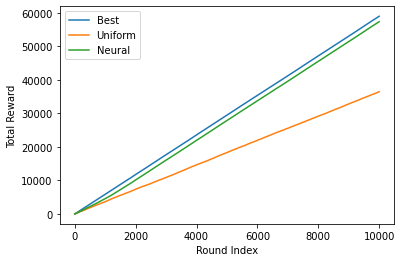

In [4]:
import matplotlib.pyplot as plt
h_r_b = bestagent.GetHistoryReward()
plt.plot(range(0, T), np.cumsum(h_r_b))

h_r_u = uniformagent.GetHistoryReward()
plt.plot(range(0, T), np.cumsum(h_r_u))

h_r_n = deepcopy(neuralagent.history_reward)
plt.plot(range(0, T), np.cumsum(h_r_n))

plt.legend(["Best", "Uniform", "Neural"])
plt.xlabel("Round Index")
plt.ylabel("Total Reward")

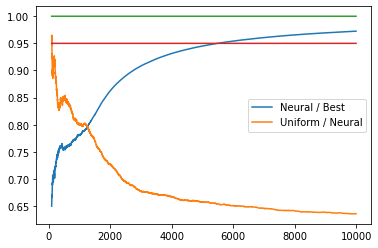

In [5]:
plt.plot(range(100, T), np.cumsum(h_r_n)[100:T] / np.cumsum(h_r_b)[100:T])
plt.plot(range(100, T), np.cumsum(h_r_u)[100:T] / np.cumsum(h_r_n)[100:T])
plt.legend(["Neural / Best", "Uniform / Neural"])
plt.plot(range(100, T), np.ones(T)[100:T])
plt.plot(range(100, T), 0.95 * np.ones(T)[100:T])

Text(0.5, 1.0, 'The ratio of of adopting same decision')

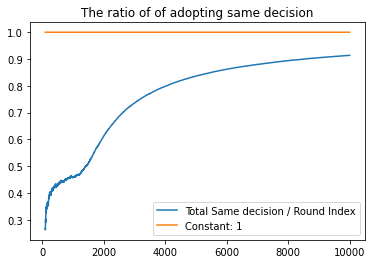

In [6]:
action_match = np.cumsum(neuralagent.history_action == bestagent.history_action)
action_match_ratio = action_match / np.array(range(1, T + 1))
plt.plot(range(100, T), action_match_ratio[100:T])
plt.plot(range(100, T), np.ones(T)[100:T])
plt.legend(["Total Same decision / Round Index", "Constant: 1"])
plt.title("The ratio of of adopting same decision")